In [1]:
import dgl
import torch
import numpy as np
import pandas as pd
import pickle as pk
import anndata as ad
from torch import nn
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from dgl.data import DGLDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import summary
from dgl.dataloading import GraphDataLoader
from pytorch_metric_learning import losses, miners, reducers, distances
import sklearn
import scanpy as sc
import anndata as ad
from sklearn.metrics.pairwise import cosine_similarity
from pytorch_metric_learning import losses, miners, reducers, distances

from dgl.nn.pytorch import GATConv, SumPooling, AvgPooling, MaxPooling
from dgl.nn import GraphConv, SAGEConv
from torch_geometric.nn import TransformerConv, global_mean_pool, global_max_pool

import torch
import torch.nn.functional as F
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
import dash
import dash_cytoscape as cyto
from dash import html, dcc
from dash.dependencies import Input, Output

from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

class GraphTransformerModel(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, num_classes, num_layers=4, heads=4, dropout=0.1):
        super(GraphTransformerModel, self).__init__()
        self.input_dim = input_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.dropout = dropout
        edge_hidden_dim = 1

        # Input projection for node features
        self.node_embedding = nn.Linear(input_dim, hidden_dim)
        self.edge_embedding = nn.Linear(edge_dim, edge_hidden_dim)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerConv(input_dim + hidden_dim, hidden_dim, heads=heads, dropout=dropout, edge_dim=edge_hidden_dim)
        ])
        for _ in range(num_layers):
            self.transformer_layers.append(TransformerConv(input_dim + (hidden_dim)*heads, hidden_dim, heads=heads, dropout=dropout, edge_dim=edge_hidden_dim))

        # Global pooling
        self.global_pooling = global_mean_pool

        # Output layer
        self.output_layer = nn.Linear((hidden_dim)*heads, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        x: Node features [num_nodes, input_dim]
        edge_index: Graph connectivity [2, num_edges]
        edge_attr: Edge features [num_edges, edge_dim]
        batch: Batch vector [num_nodes] mapping nodes to graphs
        """
        imp_emb = x

        # Embed node and edge features
        x = self.node_embedding(x)  # [num_nodes, hidden_dim]
        x = F.sigmoid(x)
        edge_attr = self.edge_embedding(edge_attr)  # [num_edges, hidden_dim]
        edge_attr = F.sigmoid(edge_attr)

        # Apply transformer layers
        for i, transformer in enumerate(self.transformer_layers):
            x = transformer(torch.concat([x, imp_emb], axis=-1), edge_index, edge_attr)
            x = F.sigmoid(x)  # Apply non-linearity
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling for graph classification
        x = self.global_pooling(x, batch)  # [num_graphs, hidden_dim]
        x = self.output_layer(x)  # [num_graphs, num_classes]

        return x

model = GraphTransformerModel(input_dim=39, edge_dim=1, hidden_dim=39, num_classes=1, num_layers=2, heads=1, dropout=0.1)

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adataClinical = ad.read_h5ad(r'../adjTMA_cleangmm.h5ad')

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adataClinical

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos'

In [4]:
adataClinical.obs[['Relapse_followup', "Surv_Followup"]]

Relapse_followup  Surv_Followup
0                   1968         1968.0
1                   1968         1968.0
2                   1968         1968.0
3                   1968         1968.0
4                   1968         1968.0
...                  ...            ...
1187506              416          530.0
1187507              416          530.0
1187508              416          530.0
1187509              416          530.0
1187510              416          530.0

[1187511 rows x 2 columns]

In [6]:
#model = torch.load('anomalous.pt')
model = torch.load('meta_learnRelapse_GraphTransformerNet_PoissonAug_Mar2nd2025_trainIds.pt', weights_only=False)

In [8]:
model.load_state_dict(torch.load('meta_learnRelapse_GraphTransformerNet_PoissonAug_Mar2nd2025_trainIds_dict.pt', weights_only=True))

<All keys matched successfully>

In [10]:
model

GraphTransformerModel(
  (node_embedding): Linear(in_features=56, out_features=28, bias=True)
  (edge_embedding): Linear(in_features=1, out_features=1, bias=True)
  (transformer_layers): ModuleList(
    (0-2): 3 x TransformerConv(84, 28, heads=1)
  )
  (output_layer): Linear(in_features=28, out_features=1, bias=True)
)

In [ ]:
df = adataClinical.obs[['CT_final', 'x', 'y', 'unique_core', 'Relapse', 'Relapse_status', 'Relapse_followup', 'Surv_status', 'Surv_Followup', 
       'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'pd1_median_pos', 
       'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'pdl1_median_pos',
       'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos',
       'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'protein_exp_nb', 'Hypoxic',
       'OxPhos', 'Mitochondrial', 'Oxidative_Stress', 'Lipid_Oxidation', 'PPP',
       'Glutamine_import']]

trainIds = ['TMA_A_A2', 'TMA_A_A5', 'TMA_A_A6', 'TMA_A_C1', 'TMA_A_C6', 'TMA_A_C7', 'TMA_A_E4', 'TMA_A_E6', 'TMA_A_E7', 'TMA_A_G2', 'TMA_A_G5', 'TMA_A_G6', 'TMA_A_G7', 'TMA_A_I7', 'TMA_B_A1', 'TMA_B_A2', 'TMA_B_A6', 'TMA_B_C3', 
            'TMA_B_C7', 'TMA_B_E5', 'TMA_B_G5', 'TMA_B_G6', 'TMA_B_I2', 'TMA_B_I3', 'TMA_A_B3', 'TMA_A_B4', 'TMA_A_B7', 'TMA_A_D5', 'TMA_A_F1', 'TMA_A_F3', 'TMA_A_F5', 'TMA_A_H1', 'TMA_A_J2', 'TMA_A_J4', 'TMA_A_J5', 'TMA_A_J6', 
            'TMA_B_B8', 'TMA_B_D1', 'TMA_B_D2', 'TMA_B_D6', 'TMA_B_D8', 'TMA_B_F2', 'TMA_B_F3', 'TMA_B_F4', 'TMA_B_F8', 'TMA_B_H4', 'TMA_B_H7', 'TMA_B_J7', 'TMA_A_C2', 'TMA_A_C3', 'TMA_B_D4', 'TMA_B_C5', 'TMA_B_G1', 'TMA_B_G3', 
            'TMA_B_I8',]

In [73]:
pd.Series(adataClinical.obs['unique_core'].unique())[~pd.Series(adataClinical.obs['unique_core'].unique()).isin(trainIds)].shape

(55,)

In [74]:
len(trainIds)

55

In [75]:
df

CT_final        x        y unique_core Relapse  Relapse_status  \
0            Tumour   2276.4   1257.7    TMA_A_A1      No             0.0   
1            Tumour   2254.4   1261.8    TMA_A_A1      No             0.0   
2            Tumour   2234.1   1265.9    TMA_A_A1      No             0.0   
3         CD4_cells   2315.7   1273.0    TMA_A_A1      No             0.0   
4            Tumour   2235.7   1276.6    TMA_A_A1      No             0.0   
...             ...      ...      ...         ...     ...             ...   
1187506  Fibroblast  15794.7  25948.8    TMA_B_J8     Yes             1.0   
1187507      Tumour  15808.1  25947.6    TMA_B_J8     Yes             1.0   
1187508      Tumour  15816.2  25947.9    TMA_B_J8     Yes             1.0   
1187509   CD8_cells  15825.7  25947.6    TMA_B_J8     Yes             1.0   
1187510  Fibroblast  15759.2  25948.4    TMA_B_J8     Yes             1.0   

        Relapse_followup  Surv_status  Surv_Followup  HLA-DR_pos  ...  \
0                   1968          0.0         1968.0  HLA-DR_neg  ...   
1                   1968          0.0         1968.0  HLA-DR_neg  ...   
2                   1968          0.0         1968.0  HLA-DR_neg  ...   
3                   1968          0.0         1968.0  HLA-DR_neg  ...   
4                   1968          0.0         1968.0  HLA-DR_neg  ...   
...                  ...          ...            ...         ...  ...   
1187506              416          1.0          530.0  HLA-DR_neg  ...   
1187507              416          1.0          530.0  HLA-DR_neg  ...   
1187508              416          1.0          530.0  HLA-DR_neg  ...   
1187509              416          1.0          530.0  HLA-DR_neg  ...   
1187510              416          1.0          530.0  HLA-DR_neg  ...   

        CPT1A_pos CITRATE_SYNTHASE_pos       protein_exp_nb Hypoxic OxPhos  \
0             neg    CITRATE_SYNTHASE+               Oxphos   False  False   
1             neg                  neg               Oxphos   False  False   
2             neg    CITRATE_SYNTHASE+                  low   False  False   
3             neg    CITRATE_SYNTHASE+                  low   False  False   
4             neg    CITRATE_SYNTHASE+                  low   False  False   
...           ...                  ...                  ...     ...    ...   
1187506    CPT1A+                  neg  Glutamineimport_PPP   False  False   
1187507       neg                  neg  Glutamineimport_PPP   False  False   
1187508       neg                  neg  Glutamineimport_PPP   False  False   
1187509    CPT1A+                  neg  Glutamineimport_PPP   False  False   
1187510       neg                  neg  Glutamineimport_PPP    True  False   

        Mitochondrial  Oxidative_Stress Lipid_Oxidation    PPP  \
0               False             False           False   True   
1               False             False           False   True   
2               False             False           False   True   
3               False             False           False   True   
4               False             False           False  False   
...               ...               ...             ...    ...   
1187506         False             False            True   True   
1187507         False             False           False   True   
1187508         False             False           False   True   
1187509         False             False            True   True   
1187510         False             False           False   True   

        Glutamine_import  
0                  False  
1                   True  
2                  False  
3                  False  
4                  False  
...                  ...  
1187506            False  
1187507            False  
1187508            False  
1187509            False  
1187510            False  

[1187511 rows x 32 columns]

In [4]:
ct_cols = ['Tumour', 'Other_Stromal_cells', 'Macrophages', 'Fibroblast',
                  'CD4_cells', 'Vessels', 'CD8_cells', 'CD44+', 'MHC_II',
                  'Macrophages_M2', 'B_cells', 'Proliferating', 'MHC_II_CD44+',
                  'MHC_I', 'MHC_I&II', 'MHC_I_CD44+', 'Proliferating_MHC_I',
                  'Macrophages_M2_PDL1+', 'Macrophages_PDL1+',
                  'MHC_I&II_CD44+', 'PDL1_MHC_I&II', 'CD44+_PDL1+',
                  'Proliferating_CD44+', 'CD4_TFH', 'PDL1+', 'PD1+_CD8_cells',
                  'Cytotoxic_CD8_cells', 'PDL1_MHC_I', 'Proliferating_PDL1',
                  'PDL1_MHC_II', 'Proliferating_MHC_II', 'PDL1_MHC_I&II_CD44+',
                  'Proliferating_MHC_I&II', 'PDL1_MHC_I_CD44+']
functional_cols = ['pdl1_median_pos',
                     'pd1_median_pos',
                     'HLA-DR_pos',
                     'HLA-A_pos',
                     'ICOS(CD278)_pos',
                     'Ki67_pos',
                     'G6PD_pos',
                     'pNRF2_pos',
                     'ATPA5_pos',
                     'GLUT1_pos',
                     'Hexokinase1_pos',
                     'ASCT2_pos',
                     'SDHA_pos',
                     'CPT1A_pos',
                     'CITRATE_SYNTHASE_pos',
                     'Hypoxic',
                     'OxPhos',
                     'Mitochondrial',
                     'Oxidative_Stress',
                     'Lipid_Oxidation',
                     'PPP',
                     'Glutamine_import']

# For plotting
mini_functional_cols = ['pdl1_median_pos',
                     'pd1_median_pos',
                     'HLA-DR_pos',
                     'HLA-A_pos',
                     'ICOS(CD278)_pos',
                     'Ki67_pos',
                     'Hypoxic',
                     'OxPhos',
                     'Mitochondrial',
                     'Oxidative_Stress',
                     'Lipid_Oxidation',
                     'PPP',
                     'Glutamine_import']
marker_cols = ct_cols + functional_cols

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
df_orig = pd.read_csv(r'graphData_adjTMA.csv')

/tmp/ipykernel_3268/208254551.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv(r'graphData_adjTMA.csv')


# Traditional Evaluation

In [79]:
def returnKNNNeighbors(ndf, xcol, ycol, rad):
    edges, distances = [], []
    points = np.array([[a, b] for a, b in zip(ndf[xcol].to_numpy(), ndf[ycol].to_numpy()) ])
    
    tree = KDTree(points, leaf_size=2)
    all_nn_indices = tree.query_radius(points, r=rad)

    cdists = cdist(points, points)

    for i in range(len(all_nn_indices)):
        for j in range(len(all_nn_indices[i])):
            if i != all_nn_indices[i][j]:
                edges.append([i, all_nn_indices[i][j]])
                distances.append(cdists[i, all_nn_indices[i][j]])
    return np.array(edges), np.array(distances)

cell_types_cols = list(sorted(set(df['CT_final'])))

def returnGraph(patientdf, rad, extras=False):
    edges, distances = returnKNNNeighbors(patientdf, xcol='x', ycol='y', rad=rad)
    edges_data = pd.DataFrame(edges, columns=['source', 'destination'])
    edges_data['distances'] = distances#Added for WGAT

    node_features = pd.get_dummies(patientdf["CT_basetumour"]).reindex(columns=cell_types_cols, fill_value=False).astype(int).astype(float)
    node_features = pd.concat([node_features, patientdf[functional_cols]], axis=1)
    node_features = torch.from_numpy(node_features.to_numpy()).float()

    node_labels = torch.from_numpy(
        patientdf["Relapse"].values).long()#.astype("category").cat.codes.to_numpy()

    edges_src = torch.from_numpy(edges_data["source"].to_numpy())
    edges_dst = torch.from_numpy(edges_data["destination"].to_numpy())
    graph = dgl.graph(
        (edges_src, edges_dst), num_nodes=len(node_features)#patientdf.shape[0]
    )
    graph.ndata["feat"] = node_features
    graph = dgl.to_bidirected(graph, copy_ndata=True)

    graph.edata['dist'] = torch.from_numpy(edges_data["distances"].to_numpy() / 50.0).float()
   
    return graph, patientdf["Relapse"].iloc[0], [1]

    
class YTMAGraphs(DGLDataset):
    def __init__(self, patient_indices):
        self.patient_indices = patient_indices
        self.bg = None
        self.metas = None
        self.sampling_layers=1
        super().__init__(name="ytma")

    def process(self):
        self.bg, self.metas = returnBG(self.patient_indices)

    def __getitem__(self, i):
        numLayers = max(np.random.poisson(self.sampling_layers), 1)
        subgraph, _ = dgl.khop_in_subgraph(self.bg, i, numLayers)
        subgraph = graph_augmentation_pipeline(subgraph)

        return subgraph, self.bg.ndata['labels'][i], self.metas[int(self.bg.ndata['graph'][i])]+[i]

    def __len__(self):
        return self.bg.num_nodes()

def returnBG(patients):
    gS, lS, metaS = returnGraphs(patients)
    bg = dgl.batch(gS)
    return bg, metaS

def returnGraphs(patients_to_select):
    batchI, totalGraphs = 0, 0
    graphs, labels, patients_ids, metas = [], [], [], []
    for graphI, (patient_id, patdf) in enumerate(df.groupby(by='unique_core')):
        if np.isnan(patdf['Relapse'].iloc[0]) or type(patdf['Relapse'].iloc[0]) == str or \
            patdf['unique_core'].iloc[0] not in patients_to_select:
            continue

        g, l, meta = returnGraph(patdf, 80.0)
        g = dgl.add_self_loop(g, fill_data=0.0)
        g.ndata['labels'] = l*torch.ones(g.num_nodes())
        g.ndata['graph'] = totalGraphs*torch.ones(g.num_nodes())
        g.ndata['nid'] = torch.tensor(list(range(g.num_nodes())))

        graphs.append(g)
        labels.append(l)
        patients_ids.append(patient_id)
        metas.append(meta)
        totalGraphs += 1

    return graphs, labels, metas

In [80]:
inds = list(range(len(set(df['unique_core']))))

In [81]:
df.unique_core = df.unique_core.astype(str)

/tmp/ipykernel_3268/4097675140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.unique_core = df.unique_core.astype(str)


In [82]:
def returnGraphWithXY(patientdf, types, rad):
    edges, distances = returnKNNNeighbors(patientdf, xcol='x', ycol='y', rad=rad)
    edges_data = pd.DataFrame(edges, columns=['source', 'destination'])
    edges_data['distances'] = distances/50.0

    node_features = pd.get_dummies(patientdf['CT_final']).reindex(columns=types, fill_value=False).astype(int).astype(float)
    node_features = pd.concat([node_features, patientdf[functional_cols]], axis=1)

    node_features = torch.from_numpy(node_features.to_numpy()).float()

    node_labels = torch.from_numpy(
        patientdf["Relapse"].to_numpy()).long()

    edges_src = torch.from_numpy(edges_data["source"].to_numpy())
    edges_dst = torch.from_numpy(edges_data["destination"].to_numpy())
    graph = dgl.graph(
        (edges_src, edges_dst), num_nodes=len(node_features)#patientdf.shape[0]
    )
    graph.ndata["feat"] = node_features
    graph.ndata['X'] = torch.from_numpy(patientdf['x'].to_numpy())
    graph.ndata['Y'] = torch.from_numpy(patientdf['y'].to_numpy())
    #graph.ndata['CT_final'] = torch.from_numpy(patientdf['CT_final'].to_numpy())
    if patientdf['Relapse_followup'].iloc[0] != '#VALUE!':
        graph.ndata['Relapse_followup'] = torch.from_numpy(np.array(patientdf['Relapse_followup'].to_numpy(), dtype=np.float64))
    else:
        graph.ndata['Relapse_followup'] = torch.from_numpy(np.nan*np.ones_like(np.array(patientdf['Relapse_followup'].to_numpy()), dtype=np.float64))
    graph.ndata['Relapse_status'] = torch.from_numpy(patientdf['Relapse_status'].to_numpy())
    graph.ndata['Surv_Followup'] = torch.from_numpy(patientdf['Surv_Followup'].to_numpy())
    graph.ndata['Surv_status'] = torch.from_numpy(patientdf['Surv_status'].to_numpy())
    graph = dgl.to_bidirected(graph, copy_ndata=True)

    graph.edata['dist'] = torch.from_numpy(edges_data["distances"].to_numpy()).float()

    return graph, patientdf["Relapse"].iloc[0]

In [83]:
keys = ['Relapse'] + functional_cols

def mapping(x):
    if type(x) == bool:
        return int(x)

    if not type(x) is str:
        return float(x)
        
    if 'neg' in x:
        return 0
    elif 'pos' in x or '+' in x:
        return 1
    elif 'Yes' in x:
        return 1
    elif 'No' in x:
        return 0
    else:
        print("ERROR\t", key)
        return x
    
for key in keys:
    df[key] = df[key].apply(mapping)

/tmp/ipykernel_3268/1365905016.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df[key].apply(mapping)


In [84]:
df.keys()

Index(['CT_final', 'x', 'y', 'unique_core', 'Relapse', 'Relapse_status',
       'Relapse_followup', 'Surv_status', 'Surv_Followup', 'HLA-DR_pos',
       'HLA-A_pos', 'ICOS(CD278)_pos', 'pd1_median_pos', 'Ki67_pos',
       'G6PD_pos', 'pNRF2_pos', 'pdl1_median_pos', 'ATPA5_pos', 'GLUT1_pos',
       'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos', 'CPT1A_pos',
       'CITRATE_SYNTHASE_pos', 'protein_exp_nb', 'Hypoxic', 'OxPhos',
       'Mitochondrial', 'Oxidative_Stress', 'Lipid_Oxidation', 'PPP',
       'Glutamine_import'],
      dtype='object')

In [85]:
from torch import linalg as LA

def outputGraph(df_):
    patients, predictions, xs, ys, labels, cts, extras = [], [], [], [], [], [], []

    batchI, totalGraphs = 0, 0
    for graphI, (patient, patdf) in enumerate(df_.groupby(by='unique_core')):
        print("graphI: ", graphI)
        if np.isnan(patdf['Relapse'].iloc[0]):
            continue

        g, l = returnGraphWithXY(patdf, ct_cols, 80)
        maxG = g.number_of_nodes()
        distsances = []

        for nodeI in range(g.number_of_nodes()):
            if nodeI % 100 == 0:
                print(nodeI, end='\r')
            subgraph, _ = dgl.khop_in_subgraph(g, nodeI, 2)
            subgraph.ndata['label'] = torch.tensor(l*np.ones(subgraph.number_of_nodes())).long()
            subgraph.ndata['batch'] = torch.tensor(batchI*np.ones(subgraph.number_of_nodes(), dtype=np.int32)).long()
            batchI += 1

            subgraph.y = l
            src, dst = subgraph.edges()
            edge_index = torch.stack([src, dst], dim=0)
            subgraph.edata['edge_index'] = edge_index.T.long()

            edges = torch.vstack(subgraph.edges())

            num_nodes = subgraph.batch_num_nodes()
            graph_ids = torch.repeat_interleave(torch.arange(len(num_nodes)), num_nodes)
            distsances.extend( subgraph.edata["dist"].detach().cpu().numpy())
            
            if graphI == 0 and nodeI == 0:
                print(summary(model.to(device), subgraph.ndata["feat"].float().to(device), edges.to(device), subgraph.edata["dist"].unsqueeze(-1).float().to(device), graph_ids.to(device)))

            pred = model(subgraph.ndata['feat'].to(device), edges.to(device), subgraph.edata["dist"].unsqueeze(-1).float().to(device), graph_ids.to(device)).sigmoid().detach().cpu()

            patients.append(patient)
            predictions.append(pred.detach().cpu().numpy())
            xs.append(g.ndata['X'][nodeI].detach().cpu().numpy())
            ys.append(g.ndata['Y'][nodeI].detach().cpu().numpy())
            labels.append(l)
            cts.append('_'.join(sorted([marker_cols[i] for i in np.where(g.ndata['feat'].detach().cpu().numpy()[nodeI] > 0.5)[0] if i < len(ct_cols)])))
            extras.append(patdf.reset_index().iloc[nodeI][['pdl1_median_pos', 'pd1_median_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos',
                   'Ki67_pos', 'G6PD_pos',
                   'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos',
                   'SDHA_pos', 'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'protein_exp_nb',
                   'Hypoxic', 'OxPhos', 'Mitochondrial', 'Oxidative_Stress',
                   'Lipid_Oxidation', 'PPP', 'Glutamine_import', 'CT_final']])

    return cts, labels, xs, ys, predictions, patients, extras

cts, labels, xs, yx, predictions, patients, extras = outputGraph(df)

graphI:  0
+----------------------------------+----------------------------------------+----------------+----------+
| Layer                            | Input Shape                            | Output Shape   | #Param   |
|----------------------------------+----------------------------------------+----------------+----------|
| GraphTransformerModel            | [104, 56], [2, 4462], [4462, 1], [104] | [1, 1]         | 30,271   |
| ├─(node_embedding)Linear         | [104, 56]                              | [104, 28]      | 1,596    |
| ├─(edge_embedding)Linear         | [4462, 1]                              | [4462, 1]      | 2        |
| ├─(transformer_layers)ModuleList | --                                     | --             | 28,644   |
| │    └─(0)TransformerConv        | [104, 84], [2, 4462], [4462, 1]        | [104, 28]      | 9,548    |
| │    └─(1)TransformerConv        | [104, 84], [2, 4462], [4462, 1]        | [104, 28]      | 9,548    |
| │    └─(2)TransformerConv        

In [86]:
patients, predictions, xs, yx, labels, cts = np.array(patients), np.array(predictions), np.array(xs), np.array(yx), np.array(labels), np.array(cts)
dict_ = {'x': xs, 'y': yx, 'cell_types': cts, 'predictions': predictions.flatten(), 'patient_id': patients, 'OR': labels}
markers = ['pdl1_median_pos', 'pd1_median_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos',
                   'Ki67_pos', 'G6PD_pos',
                   'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos',
                   'SDHA_pos', 'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'protein_exp_nb',
                   'Hypoxic', 'OxPhos', 'Mitochondrial', 'Oxidative_Stress',
                   'Lipid_Oxidation', 'PPP', 'Glutamine_import']
for key in markers:
    dict_[key] = [extras[i][key] for i in range(len(xs))]
adata = ad.AnnData(obs=pd.DataFrame(dict_))

adata.write_h5ad(r'adjTMA_celltyped_with_predictions_trainedOnTraining_validatedOnValidation.h5ad')

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Or skip rerunning

In [9]:
# To match the CNs for plotting
adataCNs = ad.read_h5ad(r'adjTMA_cleanbmm_withCNs.h5ad')

In [173]:
adataCNs

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos'

In [2]:
adata = ad.read_h5ad(r'adjTMA_celltyped_with_predictions_trainedOnTraining_validatedOnValidation.h5ad')
adata.obs['protein_exp_nb'] = adata.obs['protein_exp_nb'].astype(str)

patients, predictions, xs, yx, labels, cts, PD_L1_pos, PD_1_pos, HLA_DR_pos, HLA_A_pos, ICOS_CD278_pos, Ki67_pos, G6PD_pos, pNRF2_pos, ATPA5_pos, GLUT1_pos, Hexokinase1_pos, ASCT2_pos, \
        SDHA_pos, CPT1A_pos, CITRATE_SYNTHASE_pos, protein_exp_nb, Hypoxic, OxPhos, Mitochondrial, Oxidative_Stress, Lipid_Oxidation, PPP, Glutamine_import = \
        adata.obs['patient_id'].values, adata.obs['predictions'].values, adata.obs['x'].values, adata.obs['y'].values, adata.obs['OR'].values, adata.obs['cell_types'].values, adata.obs['pdl1_median_pos'].values, adata.obs['pd1_median_pos'].values, adata.obs['HLA-DR_pos'].values, \
        adata.obs['HLA-A_pos'].values, adata.obs['ICOS(CD278)_pos'].values,adata.obs['Ki67_pos'].values,  \
        adata.obs['G6PD_pos'].values, adata.obs['pNRF2_pos'].values, adata.obs['ATPA5_pos'].values, adata.obs['GLUT1_pos'].values, adata.obs['Hexokinase1_pos'].values, adata.obs['ASCT2_pos'].values, adata.obs['SDHA_pos'].values, adata.obs['CPT1A_pos'].values, \
        adata.obs['CITRATE_SYNTHASE_pos'].values, adata.obs['protein_exp_nb'].values, adata.obs['Hypoxic'].values, adata.obs['OxPhos'].values, adata.obs['Mitochondrial'].values, adata.obs['Oxidative_Stress'].values, adata.obs['Lipid_Oxidation'].values, \
        adata.obs['PPP'].values, adata.obs['Glutamine_import'].values

In [10]:
adata.obs = pd.concat([adata.obs, adataCNs.obs[['nb_tumour_nontumour_50_2']]], axis=1)

# Plot summary stats

In [4]:
markers_for_stats = ['pdl1_median_pos', 'pd1_median_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos',
                     'Ki67_pos', 'G6PD_pos',
                     'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos',
                     'SDHA_pos', 'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 
                     'Hypoxic', 'OxPhos', 'Mitochondrial', 'Oxidative_Stress',
                     'Lipid_Oxidation', 'PPP', 'Glutamine_import']
markers = ['pdl1_pos', 'pd1_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos',
                   'Ki67_pos', 'G6PD_pos',
                   'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos',
                   'SDHA_pos', 'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 
                   'Hypoxic', 'OxPhos', 'Mitochondrial', 'Oxidative_Stress',
                   'Lipid_Oxidation', 'PPP', 'Glutamine_import', 'protein_exp_nb']

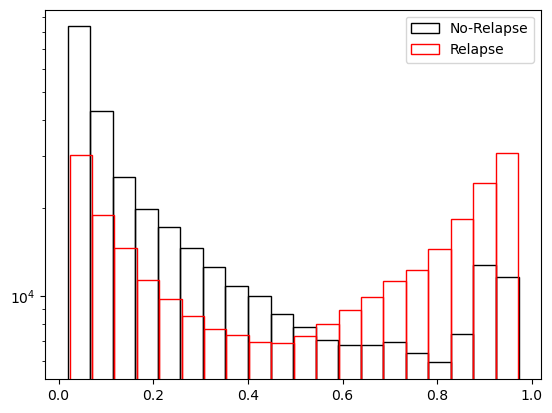

In [7]:
plt.hist(np.array(predictions).flatten()[(np.array(labels).flatten() == 0) & (~patients.isin(trainIds))], bins=20, label='No-Relapse', fill=False, edgecolor='k')
plt.hist(np.array(predictions).flatten()[(np.array(labels).flatten() == 1) & (~patients.isin(trainIds))], bins=20, label='Relapse', fill=False, edgecolor='r')
plt.legend()
plt.yscale('log')
#plt.savefig("histogram_of_embeddings_trainingset.svg")
plt.show()

In [8]:
df_ = adata.obs.copy()
df_

x        y  cell_types  predictions patient_id  OR  \
0         2276.4   1257.7      Tumour     0.787493   TMA_A_A1   0   
1         2254.4   1261.8      Tumour     0.839252   TMA_A_A1   0   
2         2234.1   1265.9      Tumour     0.830956   TMA_A_A1   0   
3         2315.7   1273.0   CD4_cells     0.849648   TMA_A_A1   0   
4         2235.7   1276.6      Tumour     0.783558   TMA_A_A1   0   
...          ...      ...         ...          ...        ...  ..   
1187506  15794.7  25948.8  Fibroblast     0.956487   TMA_B_J8   1   
1187507  15808.1  25947.6      Tumour     0.958832   TMA_B_J8   1   
1187508  15816.2  25947.9      Tumour     0.958134   TMA_B_J8   1   
1187509  15825.7  25947.6   CD8_cells     0.953808   TMA_B_J8   1   
1187510  15759.2  25948.4  Fibroblast     0.957012   TMA_B_J8   1   

         pdl1_median_pos  pd1_median_pos  HLA-DR_pos  HLA-A_pos  ...  \
0                    0.0             0.0           0          0  ...   
1                    0.0             0.0           0          0  ...   
2                    0.0             0.0           0          0  ...   
3                    0.0             0.0           0          0  ...   
4                    0.0             0.0           0          0  ...   
...                  ...             ...         ...        ...  ...   
1187506              0.0             0.0           0          0  ...   
1187507              0.0             0.0           0          0  ...   
1187508              0.0             0.0           0          0  ...   
1187509              0.0             0.0           0          0  ...   
1187510              0.0             0.0           0          0  ...   

         CPT1A_pos  CITRATE_SYNTHASE_pos       protein_exp_nb  Hypoxic  \
0                0                     1               Oxphos        0   
1                0                     0               Oxphos        0   
2                0                     1                  low        0   
3                0                     1                  low        0   
4                0                     1                  low        0   
...            ...                   ...                  ...      ...   
1187506          1                     0  Glutamineimport_PPP        0   
1187507          0                     0  Glutamineimport_PPP        0   
1187508          0                     0  Glutamineimport_PPP        0   
1187509          1                     0  Glutamineimport_PPP        0   
1187510          0                     0  Glutamineimport_PPP        1   

         OxPhos  Mitochondrial  Oxidative_Stress  Lipid_Oxidation  PPP  \
0             0              0                 0                0    1   
1             0              0                 0                0    1   
2             0              0                 0                0    1   
3             0              0                 0                0    1   
4             0              0                 0                0    0   
...         ...            ...               ...              ...  ...   
1187506       0              0                 0                1    1   
1187507       0              0                 0                0    1   
1187508       0              0                 0                0    1   
1187509       0              0                 0                1    1   
1187510       0              0                 0                0    1   

         Glutamine_import  
0                       0  
1                       1  
2                       0  
3                       0  
4                       0  
...                   ...  
1187506                 0  
1187507                 0  
1187508                 0  
1187509                 0  
1187510                 0  

[1187511 rows x 29 columns]

In [9]:
df_['pred_cat'] = np.where(df_['predictions'] > 0.5, 'Relapse', 'No-Relapse')

In [22]:
counts = df_.groupby(['patient_id', 'pred_cat', 'cell_types']).size().reset_index(name='count')
counts

/tmp/ipykernel_30825/679481504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby(['patient_id', 'pred_cat', 'cell_types']).size().reset_index(name='count')


patient_id    pred_cat              cell_types  count
0      TMA_A_A1  No-Relapse                 B_cells      0
1      TMA_A_A1  No-Relapse                 CD4_TFH      0
2      TMA_A_A1  No-Relapse               CD4_cells      0
3      TMA_A_A1  No-Relapse               CD8_cells      0
4      TMA_A_A1  No-Relapse                   CD44+      0
...         ...         ...                     ...    ...
7475   TMA_B_J8     Relapse  Proliferating_MHC_I&II     11
7476   TMA_B_J8     Relapse    Proliferating_MHC_II      2
7477   TMA_B_J8     Relapse      Proliferating_PDL1      1
7478   TMA_B_J8     Relapse                  Tumour   4553
7479   TMA_B_J8     Relapse                 Vessels   2260

[7480 rows x 4 columns]

In [23]:
totals = counts.groupby(['patient_id', 'pred_cat'])['count'].sum().reset_index(name='total')
totals

/tmp/ipykernel_30825/2854684468.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totals = counts.groupby(['patient_id', 'pred_cat'])['count'].sum().reset_index(name='total')


patient_id    pred_cat  total
0     TMA_A_A1  No-Relapse      2
1     TMA_A_A1     Relapse   4718
2     TMA_A_A2  No-Relapse   1718
3     TMA_A_A2     Relapse  10946
4     TMA_A_A3  No-Relapse    221
..         ...         ...    ...
215   TMA_B_J4     Relapse   2823
216   TMA_B_J7  No-Relapse  17543
217   TMA_B_J7     Relapse    683
218   TMA_B_J8  No-Relapse     34
219   TMA_B_J8     Relapse  15206

[220 rows x 3 columns]

In [26]:
merged = pd.merge(counts, totals, on=['patient_id', 'pred_cat'])
merged[merged['patient_id'] == 'TMA_A_A1']

patient_id    pred_cat              cell_types  count  total
0    TMA_A_A1  No-Relapse                 B_cells      0      2
1    TMA_A_A1  No-Relapse                 CD4_TFH      0      2
2    TMA_A_A1  No-Relapse               CD4_cells      0      2
3    TMA_A_A1  No-Relapse               CD8_cells      0      2
4    TMA_A_A1  No-Relapse                   CD44+      0      2
..        ...         ...                     ...    ...    ...
63   TMA_A_A1     Relapse  Proliferating_MHC_I&II      0   4718
64   TMA_A_A1     Relapse    Proliferating_MHC_II      4   4718
65   TMA_A_A1     Relapse      Proliferating_PDL1      0   4718
66   TMA_A_A1     Relapse                  Tumour   1085   4718
67   TMA_A_A1     Relapse                 Vessels    345   4718

[68 rows x 5 columns]

In [29]:
merged['proportion'] = merged['count'] / merged['total']
merged

patient_id    pred_cat              cell_types  count  total  proportion
0      TMA_A_A1  No-Relapse                 B_cells      0      2    0.000000
1      TMA_A_A1  No-Relapse                 CD4_TFH      0      2    0.000000
2      TMA_A_A1  No-Relapse               CD4_cells      0      2    0.000000
3      TMA_A_A1  No-Relapse               CD8_cells      0      2    0.000000
4      TMA_A_A1  No-Relapse                   CD44+      0      2    0.000000
...         ...         ...                     ...    ...    ...         ...
7475   TMA_B_J8     Relapse  Proliferating_MHC_I&II     11  15206    0.000723
7476   TMA_B_J8     Relapse    Proliferating_MHC_II      2  15206    0.000132
7477   TMA_B_J8     Relapse      Proliferating_PDL1      1  15206    0.000066
7478   TMA_B_J8     Relapse                  Tumour   4553  15206    0.299421
7479   TMA_B_J8     Relapse                 Vessels   2260  15206    0.148626

[7480 rows x 6 columns]

In [32]:
agg_stats = merged.groupby(['cell_types', 'pred_cat'])['proportion'].agg(
        mean='mean',
        lower=lambda x: np.nanpercentile(x, 5),
        upper=lambda x: np.nanpercentile(x, 95)
    ).reset_index()
agg_stats

/tmp/ipykernel_30825/330963432.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_stats = merged.groupby(['cell_types', 'pred_cat'])['proportion'].agg(


cell_types    pred_cat      mean     lower     upper
0              B_cells  No-Relapse  0.020612  0.000000  0.094656
1              B_cells     Relapse  0.031831  0.000000  0.140442
2              CD4_TFH  No-Relapse  0.005738  0.000000  0.026108
3              CD4_TFH     Relapse  0.003098  0.000000  0.014107
4            CD4_cells  No-Relapse  0.096386  0.012126  0.241933
..                 ...         ...       ...       ...       ...
63  Proliferating_PDL1     Relapse  0.001216  0.000000  0.009058
64              Tumour  No-Relapse  0.141828  0.005845  0.432529
65              Tumour     Relapse  0.295998  0.006742  0.668954
66             Vessels  No-Relapse  0.057908  0.007423  0.213710
67             Vessels     Relapse  0.057635  0.000000  0.198656

[68 rows x 5 columns]

In [33]:
agg_stats['err_lower'] = agg_stats['mean'] - agg_stats['lower']
agg_stats['err_upper'] = agg_stats['upper'] - agg_stats['mean']

In [34]:
pivot = agg_stats.pivot(index='cell_types', columns='pred_cat', values='mean').reset_index()
pivot

pred_cat              cell_types  No-Relapse   Relapse
0                        B_cells    0.020612  0.031831
1                        CD4_TFH    0.005738  0.003098
2                      CD4_cells    0.096386  0.064962
3                      CD8_cells    0.059677  0.037606
4                          CD44+    0.048860  0.033361
5                    CD44+_PDL1+    0.008649  0.000982
6            Cytotoxic_CD8_cells    0.002716  0.000598
7                     Fibroblast    0.106675  0.073580
8                          MHC_I    0.024955  0.021419
9                       MHC_I&II    0.012027  0.007577
10                MHC_I&II_CD44+    0.005891  0.005125
11                        MHC_II    0.030569  0.050148
12                  MHC_II_CD44+    0.014564  0.020908
13                   MHC_I_CD44+    0.015984  0.006522
14                   Macrophages    0.093067  0.095071
15                Macrophages_M2    0.031520  0.032441
16          Macrophages_M2_PDL1+    0.007553  0.003138
17             Macrophages_PDL1+    0.010840  0.011666
18           Other_Stromal_cells    0.137916  0.075522
19                PD1+_CD8_cells    0.004046  0.003295
20                         PDL1+    0.006795  0.009671
21                    PDL1_MHC_I    0.005597  0.004050
22                 PDL1_MHC_I&II    0.004354  0.000979
23           PDL1_MHC_I&II_CD44+    0.002955  0.000568
24                   PDL1_MHC_II    0.001230  0.001814
25              PDL1_MHC_I_CD44+    0.002677  0.000974
26                 Proliferating    0.012818  0.038487
27           Proliferating_CD44+    0.006450  0.003657
28           Proliferating_MHC_I    0.010125  0.002705
29        Proliferating_MHC_I&II    0.002829  0.001065
30          Proliferating_MHC_II    0.001013  0.002331
31            Proliferating_PDL1    0.005176  0.001216
32                        Tumour    0.141828  0.295998
33                       Vessels    0.057908  0.057635

In [36]:
pivot['ratio'] = pivot['No-Relapse']  / pivot['Relapse']
pivot

pred_cat              cell_types  No-Relapse   Relapse     ratio
0                        B_cells    0.020612  0.031831  0.647540
1                        CD4_TFH    0.005738  0.003098  1.851899
2                      CD4_cells    0.096386  0.064962  1.483741
3                      CD8_cells    0.059677  0.037606  1.586917
4                          CD44+    0.048860  0.033361  1.464592
5                    CD44+_PDL1+    0.008649  0.000982  8.805133
6            Cytotoxic_CD8_cells    0.002716  0.000598  4.542258
7                     Fibroblast    0.106675  0.073580  1.449784
8                          MHC_I    0.024955  0.021419  1.165079
9                       MHC_I&II    0.012027  0.007577  1.587380
10                MHC_I&II_CD44+    0.005891  0.005125  1.149453
11                        MHC_II    0.030569  0.050148  0.609569
12                  MHC_II_CD44+    0.014564  0.020908  0.696614
13                   MHC_I_CD44+    0.015984  0.006522  2.450887
14                   Macrophages    0.093067  0.095071  0.978923
15                Macrophages_M2    0.031520  0.032441  0.971599
16          Macrophages_M2_PDL1+    0.007553  0.003138  2.406821
17             Macrophages_PDL1+    0.010840  0.011666  0.929164
18           Other_Stromal_cells    0.137916  0.075522  1.826186
19                PD1+_CD8_cells    0.004046  0.003295  1.227869
20                         PDL1+    0.006795  0.009671  0.702620
21                    PDL1_MHC_I    0.005597  0.004050  1.382038
22                 PDL1_MHC_I&II    0.004354  0.000979  4.448906
23           PDL1_MHC_I&II_CD44+    0.002955  0.000568  5.202269
24                   PDL1_MHC_II    0.001230  0.001814  0.677981
25              PDL1_MHC_I_CD44+    0.002677  0.000974  2.748495
26                 Proliferating    0.012818  0.038487  0.333055
27           Proliferating_CD44+    0.006450  0.003657  1.763451
28           Proliferating_MHC_I    0.010125  0.002705  3.742644
29        Proliferating_MHC_I&II    0.002829  0.001065  2.655678
30          Proliferating_MHC_II    0.001013  0.002331  0.434673
31            Proliferating_PDL1    0.005176  0.001216  4.256818
32                        Tumour    0.141828  0.295998  0.479150
33                       Vessels    0.057908  0.057635  1.004731

In [39]:
cell_types = sorted(agg_stats['cell_types'].unique())

In [40]:
agg_stats[agg_stats['pred_cat'] == 'Relapse'].set_index('cell_types').loc[cell_types].reset_index()

cell_types pred_cat      mean     lower     upper  err_lower  \
0                  B_cells  Relapse  0.031831  0.000000  0.140442   0.031831   
1                    CD44+  Relapse  0.033361  0.000000  0.160480   0.033361   
2              CD44+_PDL1+  Relapse  0.000982  0.000000  0.003191   0.000982   
3                  CD4_TFH  Relapse  0.003098  0.000000  0.014107   0.003098   
4                CD4_cells  Relapse  0.064962  0.001304  0.180055   0.063658   
5                CD8_cells  Relapse  0.037606  0.005689  0.102355   0.031917   
6      Cytotoxic_CD8_cells  Relapse  0.000598  0.000000  0.003287   0.000598   
7               Fibroblast  Relapse  0.073580  0.013153  0.173028   0.060426   
8                    MHC_I  Relapse  0.021419  0.000000  0.094085   0.021419   
9                 MHC_I&II  Relapse  0.007577  0.000000  0.040348   0.007577   
10          MHC_I&II_CD44+  Relapse  0.005125  0.000000  0.027093   0.005125   
11                  MHC_II  Relapse  0.050148  0.000000  0.308535   0.050148   
12            MHC_II_CD44+  Relapse  0.020908  0.000000  0.077622   0.020908   
13             MHC_I_CD44+  Relapse  0.006522  0.000000  0.047072   0.006522   
14             Macrophages  Relapse  0.095071  0.007805  0.256707   0.087265   
15          Macrophages_M2  Relapse  0.032441  0.000153  0.067606   0.032288   
16    Macrophages_M2_PDL1+  Relapse  0.003138  0.000000  0.014082   0.003138   
17       Macrophages_PDL1+  Relapse  0.011666  0.000000  0.034309   0.011666   
18     Other_Stromal_cells  Relapse  0.075522  0.000958  0.180622   0.074564   
19          PD1+_CD8_cells  Relapse  0.003295  0.000000  0.015808   0.003295   
20                   PDL1+  Relapse  0.009671  0.000000  0.030085   0.009671   
21              PDL1_MHC_I  Relapse  0.004050  0.000000  0.010748   0.004050   
22           PDL1_MHC_I&II  Relapse  0.000979  0.000000  0.006164   0.000979   
23     PDL1_MHC_I&II_CD44+  Relapse  0.000568  0.000000  0.002285   0.000568   
24             PDL1_MHC_II  Relapse  0.001814  0.000000  0.012991   0.001814   
25        PDL1_MHC_I_CD44+  Relapse  0.000974  0.000000  0.001711   0.000974   
26           Proliferating  Relapse  0.038487  0.000000  0.183650   0.038487   
27     Proliferating_CD44+  Relapse  0.003657  0.000000  0.024744   0.003657   
28     Proliferating_MHC_I  Relapse  0.002705  0.000000  0.010272   0.002705   
29  Proliferating_MHC_I&II  Relapse  0.001065  0.000000  0.004618   0.001065   
30    Proliferating_MHC_II  Relapse  0.002331  0.000000  0.008342   0.002331   
31      Proliferating_PDL1  Relapse  0.001216  0.000000  0.009058   0.001216   
32                  Tumour  Relapse  0.295998  0.006742  0.668954   0.289256   
33                 Vessels  Relapse  0.057635  0.000000  0.198656   0.057635   

    err_upper  
0    0.108611  
1    0.127120  
2    0.002209  
3    0.011009  
4    0.115093  
5    0.064749  
6    0.002689  
7    0.099448  
8    0.072666  
9    0.032771  
10   0.021969  
11   0.258386  
12   0.056714  
13   0.040551  
14   0.161636  
15   0.035165  
16   0.010944  
17   0.022643  
18   0.105101  
19   0.012512  
20   0.020414  
21   0.006698  
22   0.005185  
23   0.001717  
24   0.011177  
25   0.000737  
26   0.145163  
27   0.021087  
28   0.007567  
29   0.003553  
30   0.006011  
31   0.007843  
32   0.372956  
33   0.141021

In [10]:
def plot_celltype_proportions(adata, lower_percentile=5, upper_percentile=95, ct_col='cell_types'):
    sns.set(style="whitegrid")

    df = adata.obs.copy()
    df['pred_cat'] = np.where(df['predictions'] > 0.5, 'Relapse', 'No-Relapse')
    
    counts = df.groupby(['patient_id', 'pred_cat', ct_col]).size().reset_index(name='count')
    totals = counts.groupby(['patient_id', 'pred_cat'])['count'].sum().reset_index(name='total')
    merged = pd.merge(counts, totals, on=['patient_id', 'pred_cat'])
    merged['proportion'] = merged['count'] / merged['total']

    agg_stats = merged.groupby([ct_col, 'pred_cat'])['proportion'].agg(
        mean='mean',
        lower=lambda x: np.nanpercentile(x, 5),
        upper=lambda x: np.nanpercentile(x, 95)
    ).reset_index()
    
    agg_stats['err_lower'] = agg_stats['mean'] - agg_stats['lower']
    agg_stats['err_upper'] = agg_stats['upper'] - agg_stats['mean']
    
    pivot = agg_stats.pivot(index=ct_col, columns='pred_cat', values='mean').reset_index()
    pivot['ratio'] = pivot['No-Relapse']  / pivot['Relapse']

    pivot['ratio'] = pivot['ratio'].fillna(4.0)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1], sharex=True)

    cell_types = sorted(agg_stats[ct_col].unique())
    x = np.arange(len(cell_types))
    
    prediction_categories = ['No-Relapse', 'Relapse']
    bar_width = 0.35
    
    for i, cat in enumerate(prediction_categories):
        subset = agg_stats[agg_stats['pred_cat'] == cat].set_index('cell_types').loc[cell_types].reset_index()
        medians = subset['mean']
        errors = [subset['err_lower'], subset['err_upper']]
        xpos = x + (i - 0.5) * bar_width
        axes[0].bar(xpos, medians, width=bar_width, label=cat, alpha=0.7)
        axes[0].errorbar(xpos, medians, yerr=errors, fmt='none', capsize=5, color='black')
    
    axes[0].set_title('Cell Proportions (Num+Den in Regions)in GNN-Predicted Relapse-Associated Regions')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cell_types, rotation=0)
    axes[0].legend(title='Predictions')
    axes[0].set_yscale('log')  

    pivot = pivot.set_index(ct_col).loc[cell_types].reset_index()

    axes[1].bar(x, pivot['ratio'], width=0.6, color='skyblue', alpha=0.7)
    axes[1].set_ylabel('Ratio [No-Relapse / Relapse]')
    axes[1].set_xlabel('Cell Type')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cell_types, rotation=0) s
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_ylim([-0.1, 4.0])
    axes[1].hlines(1, x[0], x[-1], lw=2)
    plt.tight_layout()
    plt.savefig("plot_celltype_proportions.svg")
    plt.show()

    return pivot

In [27]:
def plot_marker_proportions_for_marker_cols(
    adata,
    marker_cols,
    lower_percentile=5,
    upper_percentile=95,
    pred_col='predictions'
):

    sns.set(style="whitegrid")
    df = adata.obs.copy()
    df['pred_cat'] = np.where(df[pred_col] > 0.5, 'Relapse', 'No-Relapse')
    
    counts_wide = (
        df
        .groupby(['patient_id', 'pred_cat'])[marker_cols]
        .sum()
        .reset_index()
    )
    counts = (
        counts_wide
        .melt(
            id_vars=['patient_id', 'pred_cat'],
            value_vars=marker_cols,
            var_name='marker',
            value_name='count'
        )
    )

    totals = (
        df
        .groupby(['patient_id', 'pred_cat'])
        .size()
        .reset_index(name='total')
    )

    merged = counts.merge(totals, on=['patient_id', 'pred_cat'])
    merged[['count',	'total']] = merged[['count',	'total']].fillna(0)
    merged['proportion'] = merged['count'] / (merged['total'])# + 1e-5)

    agg = (
        merged
        .groupby(['marker', 'pred_cat'])['proportion']
        .agg(
            mean='mean',
            lower=lambda x: np.nanpercentile(x, lower_percentile),
            upper=lambda x: np.nanpercentile(x, upper_percentile),
        )
        .reset_index()
    )
    agg['err_lower'] = agg['mean'] - agg['lower']
    agg['err_upper'] = agg['upper'] - agg['mean']

    pivot = agg.pivot(index='marker', columns='pred_cat', values='mean').reset_index()
    pivot['ratio'] = pivot['No-Relapse'] / pivot['Relapse']
    pivot = pivot.fillna(4.0)

    # ----------- plotting -----------
    markers = sorted(agg['marker'].unique())
    x = np.arange(len(markers))
    cats = ['No-Relapse', 'Relapse']
    w = 0.35

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                   gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    for i, cat in enumerate(cats):
        sub = agg[agg['pred_cat']==cat].set_index('marker').loc[markers]
        xpos = x + (i-0.5)*w
        ax1.bar(xpos, sub['mean'], width=w, label=cat, alpha=0.7)
        ax1.errorbar(xpos, sub['mean'], 
                     yerr=[sub['err_lower'], sub['err_upper']],
                     fmt='none', capsize=5, color='black')

    ax1.set_title('Marker Proportions by Prediction Category (Num+Den in Regions)')
    ax1.set_ylabel('Proportion')
    ax1.set_yscale('log')
    ax1.legend(title='Prediction')
    ax1.set_xticks(x)
    ax1.set_xticklabels(markers, rotation=0)

    ordered = pivot.set_index('marker').loc[markers].reset_index()
    ax2.bar(x, ordered['ratio'], width=0.6, alpha=0.7)
    ax2.set_ylabel('Ratio (No-Relapse / Relapse)')
    ax2.hlines(1, x[0], x[-1], colors='gray', linestyles='dashed')
    ax2.set_xticks(x)
    ax2.set_xticklabels(markers, rotation=90)
    ax2.set_xlabel('Marker')
    ax2.set_ylim([-0.1, 4])
    plt.tight_layout()
    plt.savefig("plot_marker_proportions_for_marker_cols_tumoronly.svg")
    plt.show()

    return

/tmp/ipykernel_241766/3878029531.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['patient_id', 'pred_cat'])[marker_cols]
/tmp/ipykernel_241766/3878029531.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['patient_id', 'pred_cat'])


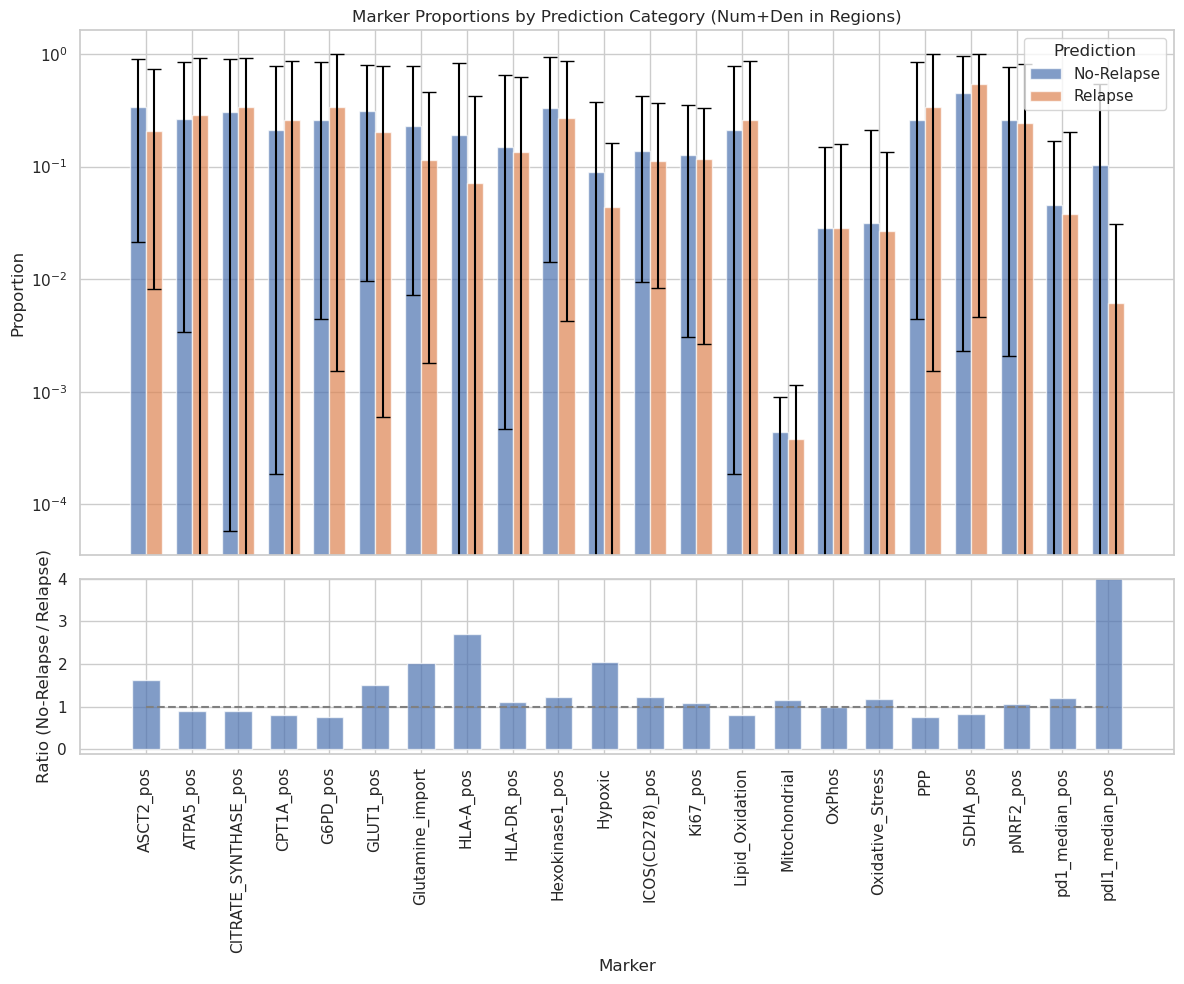

In [20]:
plot_marker_proportions_for_marker_cols(adata[~adata.obs['cell_types'].isin(['Other_Stromal_cells', 'Macrophages', 'Fibroblast', 'CD4_cells', 'CD8_cells', 'Vessels', 'Macrophages_M2', 'B_cells', 'Macrophages_PDL1+', 'Macrophages_M2_PDL1+', 'CD4_TFH', 'Cytotoxic_CD8_cells'])], marker_cols=markers_for_stats)

/tmp/ipykernel_241766/385785804.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['patient_id', 'pred_cat'])[marker_cols]
/tmp/ipykernel_241766/385785804.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['patient_id', 'pred_cat'])


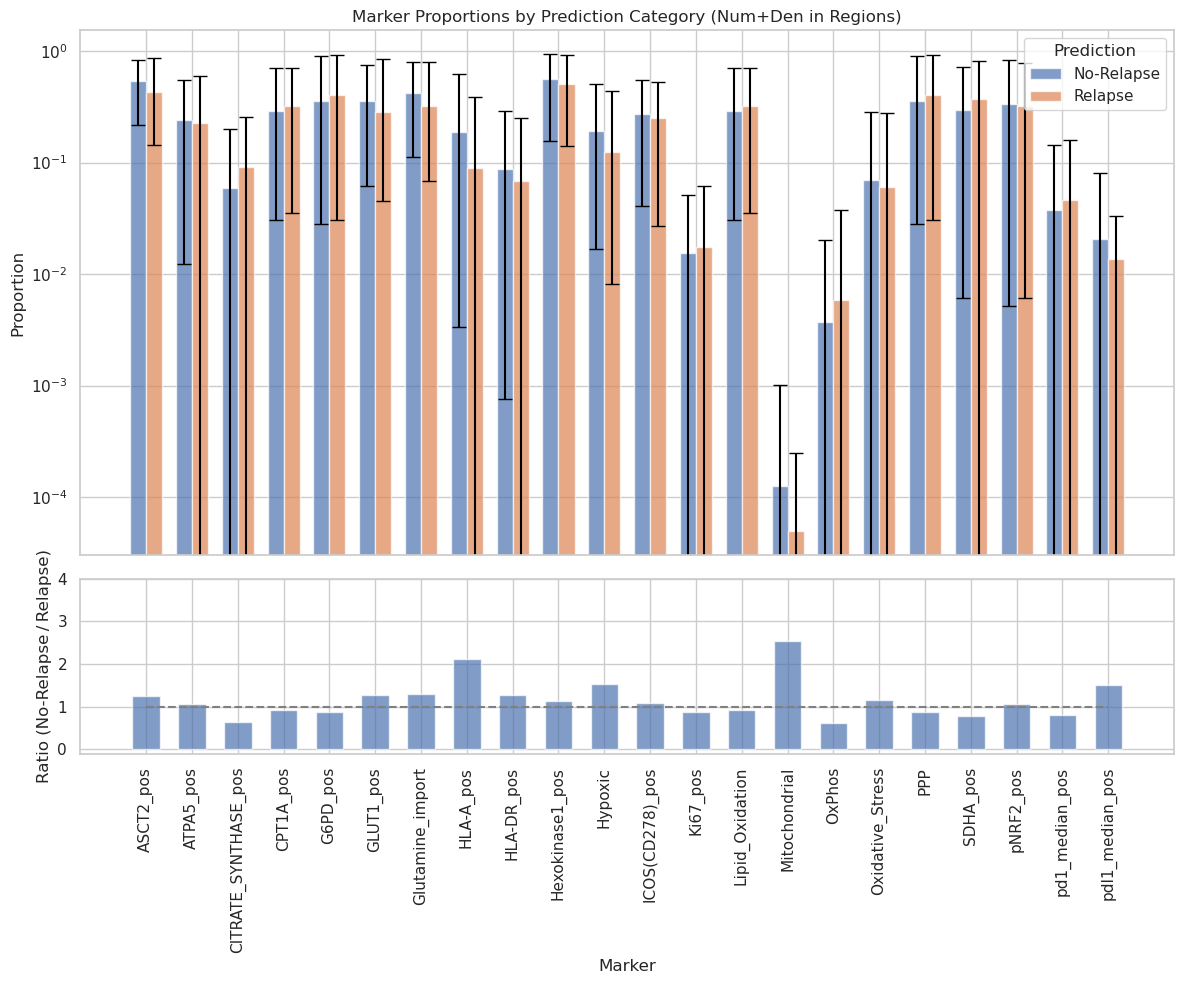

In [26]:
plot_marker_proportions_for_marker_cols(adata[adata.obs['cell_types'].isin(['Other_Stromal_cells', 'Fibroblast', 'Vessels'])], marker_cols=markers_for_stats)#'Other_Stromal_cells', 'Fibroblast', 'Vessels', 

/tmp/ipykernel_30825/1674128133.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['patient_id', 'pred_cat', ct_col]).size().reset_index(name='count')
/tmp/ipykernel_30825/1674128133.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totals = counts.groupby(['patient_id', 'pred_cat'])['count'].sum().reset_index(name='total')
/tmp/ipykernel_30825/1674128133.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

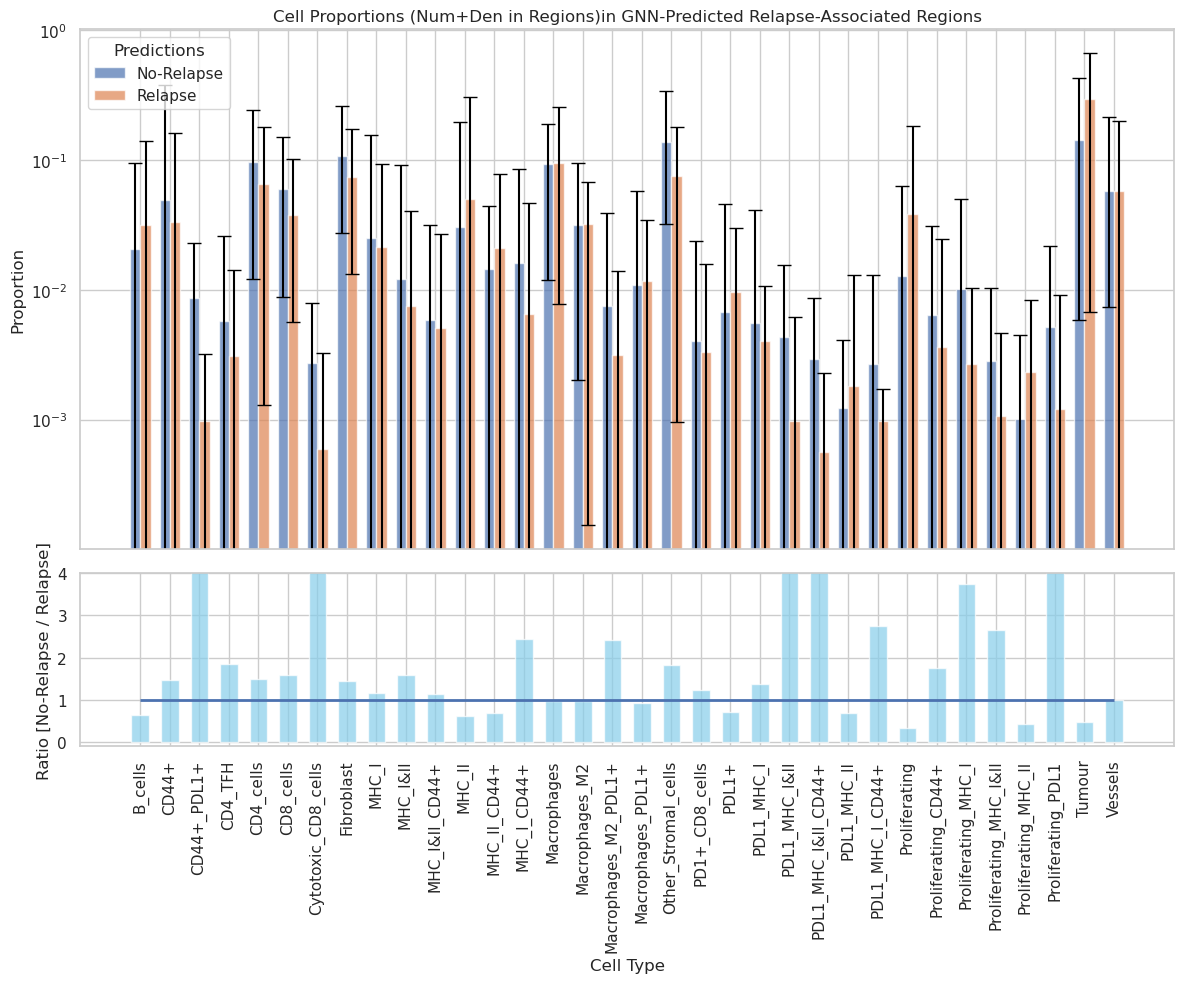

In [75]:
props_ = plot_celltype_proportions(adata, ct_col='cell_types')

In [94]:
#  Now compute whole-core proportions

In [78]:
def plot_celltype_wholecore_proportions(adata, lower_percentile=5, upper_percentile=95, ct_col='cell_types'):
    sns.set(style="whitegrid")

    df = adata.obs.copy()
    df['pred_cat'] = np.where(df['predictions'] > 0.5, 'Relapse', 'No-Relapse')
    
    counts = df.groupby(['patient_id', 'pred_cat', ct_col]).size().reset_index(name='count')
    totals = counts.groupby(['patient_id'])['count'].sum().reset_index(name='total')
    merged = pd.merge(counts, totals, on=['patient_id'])
    merged['proportion'] = merged['count'] / (merged['total'])# + 1e-5)

    agg_stats = merged.groupby([ct_col, 'pred_cat'])['proportion'].agg(
        mean='mean',
        lower=lambda x: np.nanpercentile(x, 5),
        upper=lambda x: np.nanpercentile(x, 95)
    ).reset_index()

    agg_stats['err_lower'] = agg_stats['mean'] - agg_stats['lower']
    agg_stats['err_upper'] = agg_stats['upper'] - agg_stats['mean']
    
    pivot = agg_stats.pivot(index=ct_col, columns='pred_cat', values='mean').reset_index()
    pivot['ratio'] = pivot['No-Relapse']  / pivot['Relapse']

    pivot['ratio'] = pivot['ratio'].fillna(4.0)
    pivot['ratio'] = pivot['ratio'].replace({np.inf: 4.0})
    

    fig, axes = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1], sharex=True)
    cell_types = sorted(agg_stats[ct_col].unique())
    x = np.arange(len(cell_types))
    
    prediction_categories = ['No-Relapse', 'Relapse']
    bar_width = 0.35
    
    myRatios = []
    for i, cat in enumerate(prediction_categories):
        subset = agg_stats[agg_stats['pred_cat'] == cat].set_index(ct_col).loc[cell_types].reset_index()
        medians = subset['mean']
        errors = [subset['err_lower'], subset['err_upper']]
        xpos = x + (i - 0.5) * bar_width
        axes[0].bar(xpos, medians, width=bar_width, label=cat, alpha=0.7)
        axes[0].errorbar(xpos, medians, yerr=errors, fmt='none', capsize=5, color='black')
        myRatios.append(medians)
    myRatios = myRatios[1]/myRatios[0]
    
    axes[0].set_title('Cell Proportions of Whole Core (positive counts within GNN-Predicted Relapse-Associated Regions)')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cell_types, rotation=0)
    axes[0].legend(title='Predictions')
    axes[0].set_yscale('log')  # Set the y-axis to a logarithmic scale

    pivot = pivot.set_index(ct_col).loc[cell_types].reset_index()
    
    axes[1].bar(x, pivot['ratio'], width=0.6, color='skyblue', alpha=0.7)
    axes[1].set_ylabel('Ratio [No-Relapse / Relapse]')
    axes[1].set_xlabel('Cell Type')
    axes[1].hlines(1, x[0], x[-1], 'r', ls='--', lw=2)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(cell_types, rotation=0)  # Do not rotate the x-axis labels
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_ylim([0.5, 4.0])

    plt.tight_layout()
    plt.savefig("plot_celltype_wholecore_proportions.svg")
    plt.show()

    return

/tmp/ipykernel_30825/1361542205.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['patient_id', 'pred_cat', ct_col]).size().reset_index(name='count')
/tmp/ipykernel_30825/1361542205.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totals = counts.groupby(['patient_id'])['count'].sum().reset_index(name='total')
/tmp/ipykernel_30825/1361542205.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

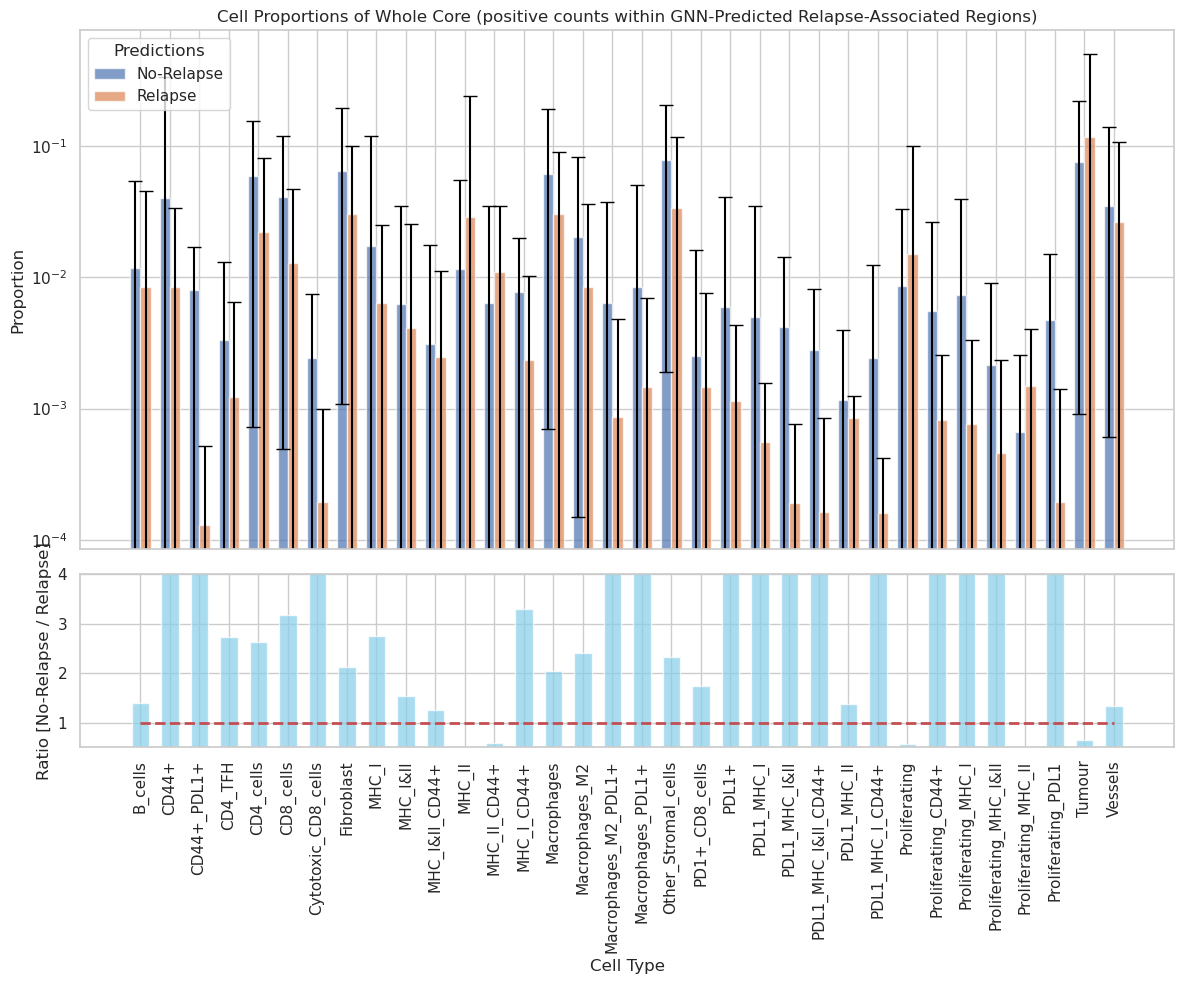

In [79]:
plot_celltype_wholecore_proportions(adata, ct_col='cell_types')

In [80]:
cell_types = sorted(adata.obs['cell_types'].unique())
n_nodes = adata.n_obs
n_cell_types = len(cell_types)

prop_matrix = np.zeros((n_nodes, n_cell_types))

for pid, idx in adata.obs.groupby('patient_id').groups.items():
    indices = list(idx)
    padata = adata[indices, :].copy().obs.reset_index(drop=True)
    coords = padata.loc[:, ['x', 'y']].values

    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto').fit(coords)
    distances, neighbors = nbrs.radius_neighbors(coords, radius=160.0)
    
    neighbors = [neighbors[i] for i in range(len(neighbors))]

    ct_series = padata['cell_types']
    
    for pos, node_idx in enumerate(indices):
        neighbor_positions = neighbors[pos]
        neighbor_ct = ct_series.iloc[neighbor_positions]
        counts = neighbor_ct.value_counts(normalize=True).reindex(index = cell_types)
        for col_idx, ct in enumerate(cell_types):
            prop_matrix[int(node_idx), col_idx] = counts.get(ct, 0)

adata.obsm['cell_type_proportions'] = prop_matrix

/tmp/ipykernel_30825/1139174547.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pid, idx in adata.obs.groupby('patient_id').groups.items():


In [81]:
df_props = pd.DataFrame(prop_matrix, index=adata.obs.index, columns=cell_types)

df_props['patient_id'] = adata.obs['patient_id']
df_props['predictions'] = adata.obs['predictions']

df_props['prediction_group'] = np.where(df_props['predictions'] > 0.5, 'Relapse', 'No-Relapse')

df_long = df_props.melt(id_vars=['patient_id', 'predictions', 'prediction_group'],
                        value_vars=cell_types,
                        var_name='cell_types',
                        value_name='proportion')


patient_summary = df_long.groupby(['patient_id', 'prediction_group', 'cell_types'])['proportion'] \
                          .mean().reset_index()
patient_summary.rename(columns={'proportion': 'patient_median'}, inplace=True)


agg_summary = patient_summary.groupby(['prediction_group', 'cell_types']).agg(
    overall_median=('patient_median', 'mean'),
    overall_q25=('patient_median', lambda x: np.nanpercentile(x, 5)),
    overall_q75=('patient_median', lambda x: np.nanpercentile(x, 95))
).reset_index()


cell_types_order = sorted(agg_summary['cell_types'].unique())
x = np.arange(len(cell_types_order))
width = 0.35  # The width for each bar in a group.

groups = sorted(agg_summary['prediction_group'].unique())

/tmp/ipykernel_30825/2399156390.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_summary = df_long.groupby(['patient_id', 'prediction_group', 'cell_types'])['proportion'] \


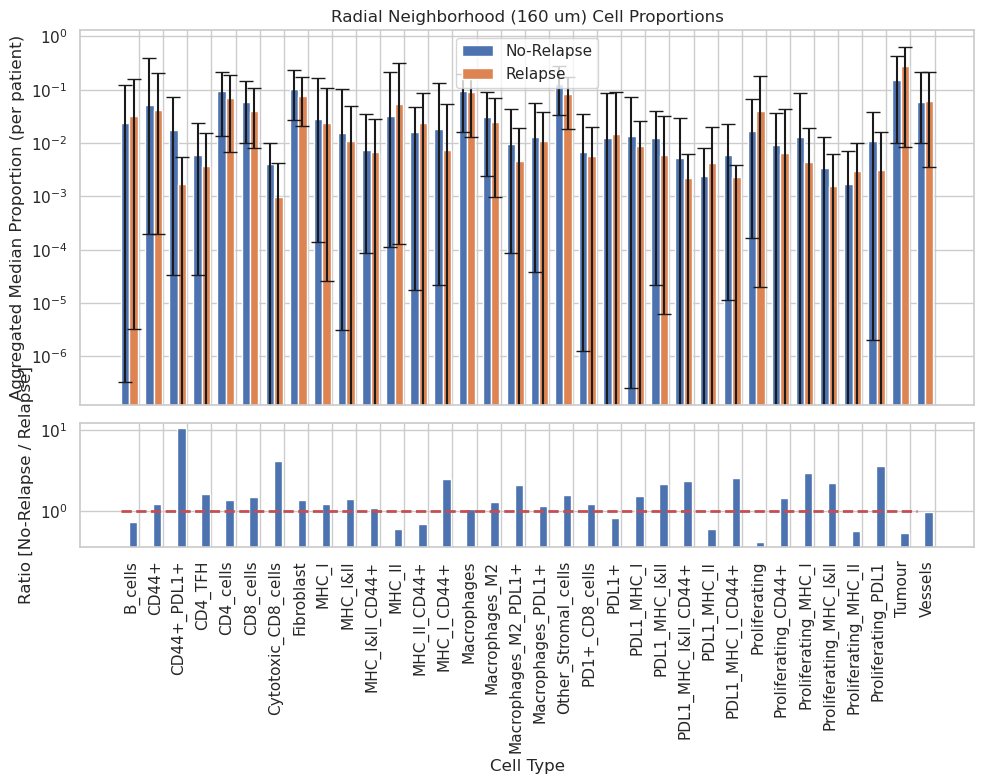

In [83]:
patient_ratio = patient_summary.pivot(index=['patient_id', 'cell_types'],
                                      columns='prediction_group',
                                      values='patient_median').reset_index()


patient_ratio['ratio'] = patient_ratio['No-Relapse'] / patient_ratio['Relapse']
patient_ratio['ratio'] = patient_ratio['ratio'].fillna(4.0)
patient_ratio['ratio'] = patient_ratio['ratio'].replace({np.inf: 4.0})

cell_types_order = sorted(agg_summary['cell_types'].unique())

x = np.arange(len(cell_types_order))
width = 0.35  # width for the proportions plot

groups = sorted(agg_summary['prediction_group'].unique())

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), height_ratios=[3, 1], sharex=True)

myRatios = []
for i, group in enumerate(groups):
    df_grp = agg_summary[agg_summary['prediction_group'] == group].set_index('cell_types').reindex(cell_types_order)
    medians = df_grp['overall_median'].values
    lower_errors = np.abs(medians - df_grp['overall_q25'].values)
    upper_errors = np.abs(df_grp['overall_q75'].values - medians)
    errors = [lower_errors, upper_errors]
    ax1.bar(x + (i + 0.5) * width, medians, width=width, yerr=errors, capsize=5, label=group)
    myRatios.append(medians)
myRatios = myRatios[0]/myRatios[1]

ax1.set_ylabel("Aggregated Median Proportion (per patient)")
ax1.set_title("Radial Neighborhood (160 um) Cell Proportions")
ax1.legend()
ax1.set_yscale('log')


ax2.bar(x+0.5, myRatios, width=width, capsize=5)
ax2.set_ylabel("Ratio [No-Relapse / Relapse]")
ax2.set_xlabel("Cell Type")

ax2.set_xticks(x+0.75)
ax2.set_xticklabels(cell_types_order, rotation=90, ha='right')
ax2.hlines(1, x[0], x[-1], 'r', ls='--', lw=2)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig("radialNeighborhoodproportions.svg")
plt.show()

# Plot in the data

In [132]:
cell_types_colors = {
        "Tumour": "#d6336f",
        "Other_Stromal_cells": "#4aa0ea", # a lighter blue; related to b cells
        "Macrophages": "#9023f6", # Brighter purple
        "Fibroblast": "#622d04", # brown, reminiscent of VIM staining with HRP DAB
        "CD4_cells": "#49ad37", # base green
        "Vessels": "#d86e53", # a redder brown / orange
        "CD8_cells": "#4a118a", # Darker purple to represent more density and size
        "CD44+": "#d6336faa",
        "MHC_II": "#d6336faa",
        "Macrophages_M2": "#cfcec1", # Muted version of the other cells
        "B_cells": "#4a65ea", # Dark blue
        "Proliferating": "#d6336fdd",
        "MHC_II_CD44+": "#d6336faa",
        "MHC_I": "#d6336faa",
        "MHC_I&II": "#d6336faa",
        "MHC_I_CD44+": "#d6336faa",
        "Proliferating_MHC_I": "#d6336fdd",
        "Macrophages_M2_PDL1+": "#87b09a", # muted green
        "Macrophages_PDL1+": "#b292d8", # Muted version of hte myeloid_cells
        "MHC_I&II_CD44+": "#d6336faa",
        "PDL1_MHC_I&II": "#d6336fff",
        "CD44+_PDL1+": "#d6336fff",
        "Proliferating_CD44+": "#d6336fff",
        "CD4_TFH": "#86807a", # Muted version of the other cells
        "PDL1+": "#d6336fff",
        "PD1+_CD8_cells": "#da6fd2", # pink, related to blood. avoid red to not confused with 'detrimental' cells like tumor cells
        "Cytotoxic_CD8_cells": "#22d595", # a more toxic, brighter turq,green to indicate killing function
        "PDL1_MHC_I": "#d6336fff",
        "Proliferating_PDL1": "#d6336fff",
        "PDL1_MHC_II": "#d6336fff",
        "Proliferating_MHC_II": "#d6336fff",
        "PDL1_MHC_I&II_CD44+": "#d6336fff",
        "Proliferating_MHC_I&II": "#d6336fff",
        "PDL1_MHC_I_CD44+": "#d6336fff",
    }

TMA_B_H4


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.11290401


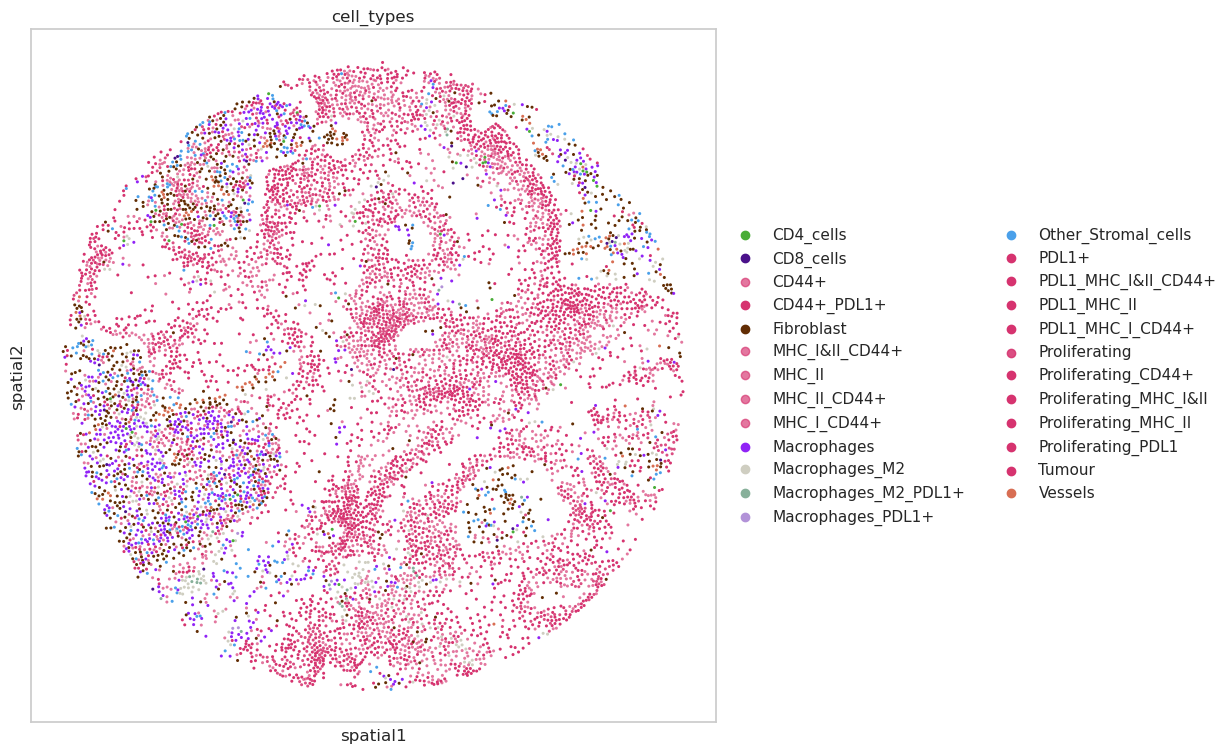

TMA_B_D8


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.057224657


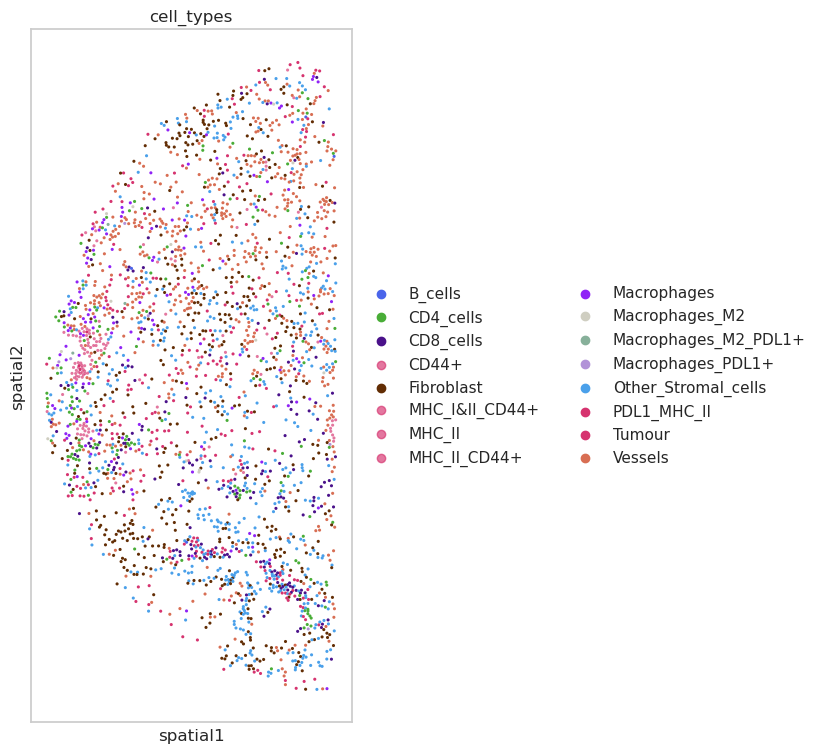

TMA_A_C7


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.4251614


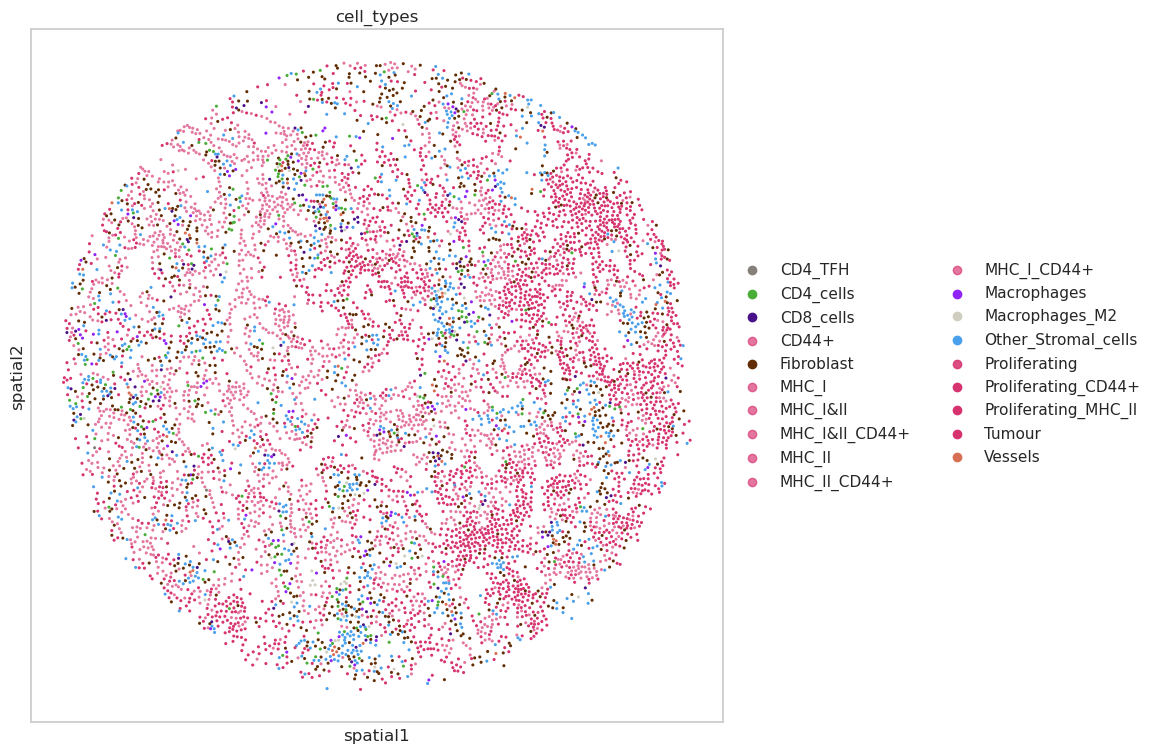

TMA_A_B6


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.61626405


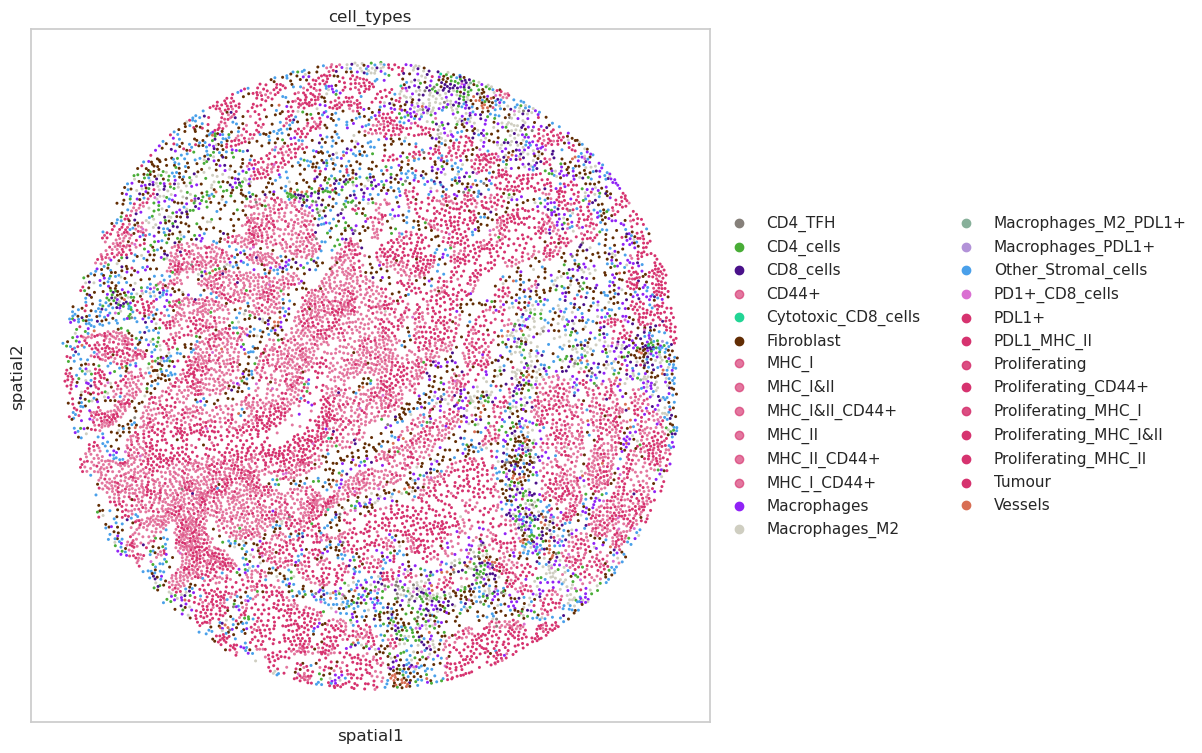

TMA_A_F3


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.6376529


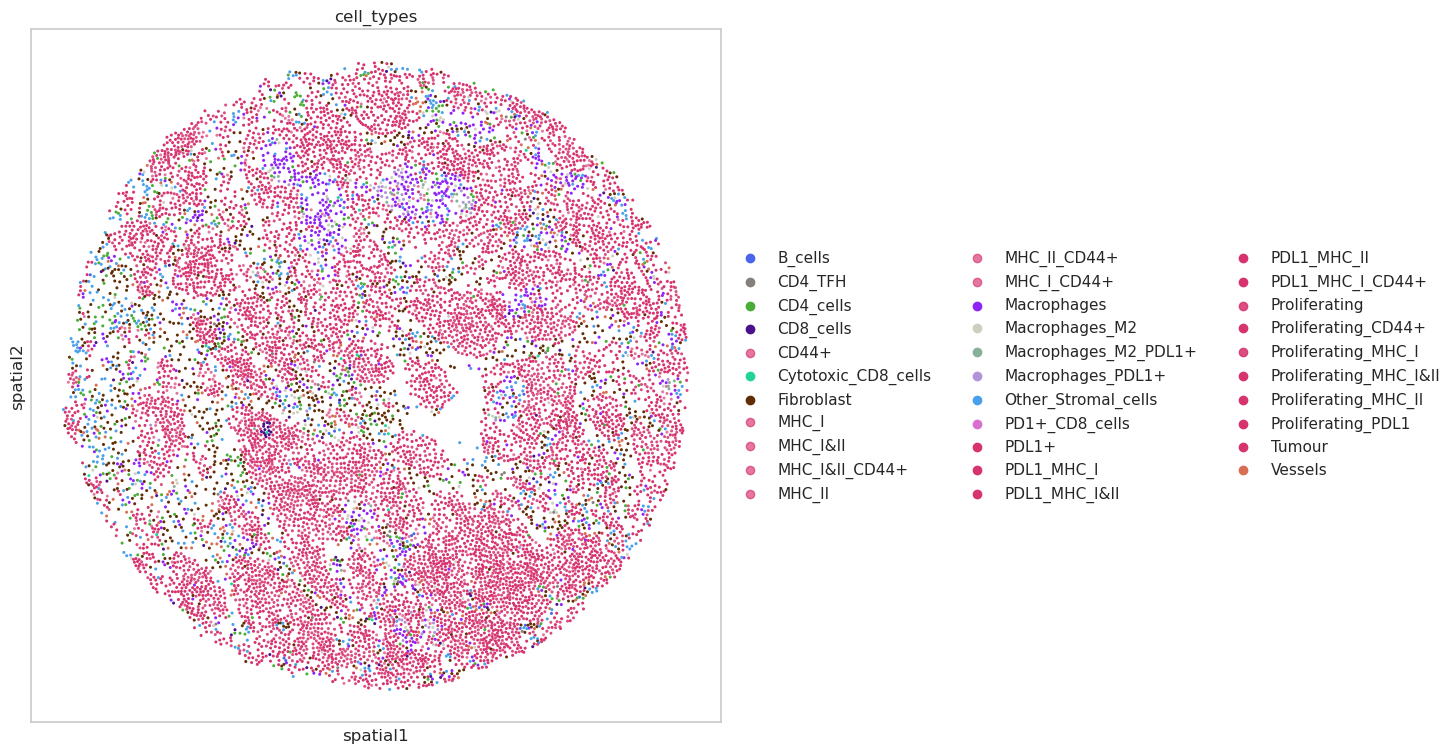

TMA_A_B4


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.21997294


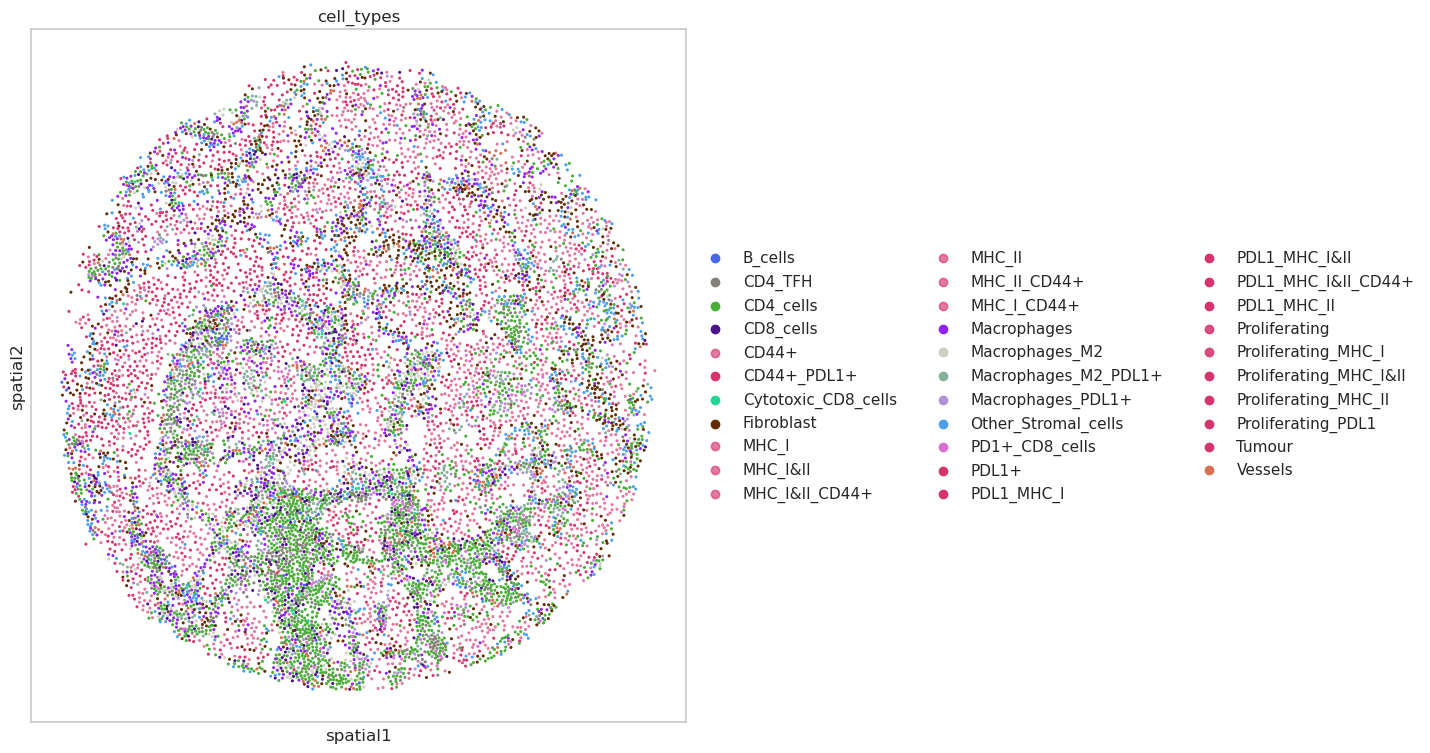

TMA_B_C8


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.11695957


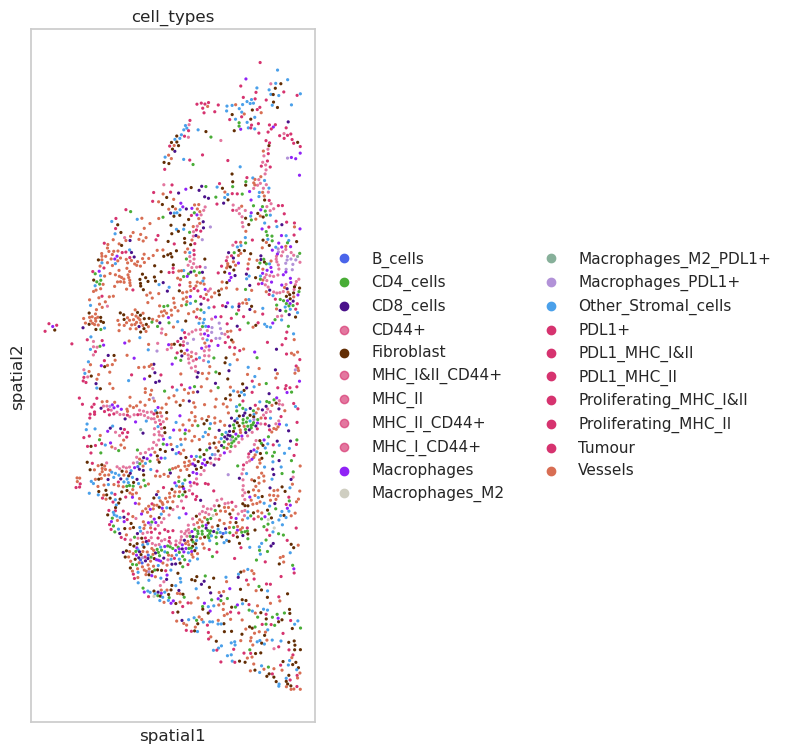

TMA_A_A7


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.53640515


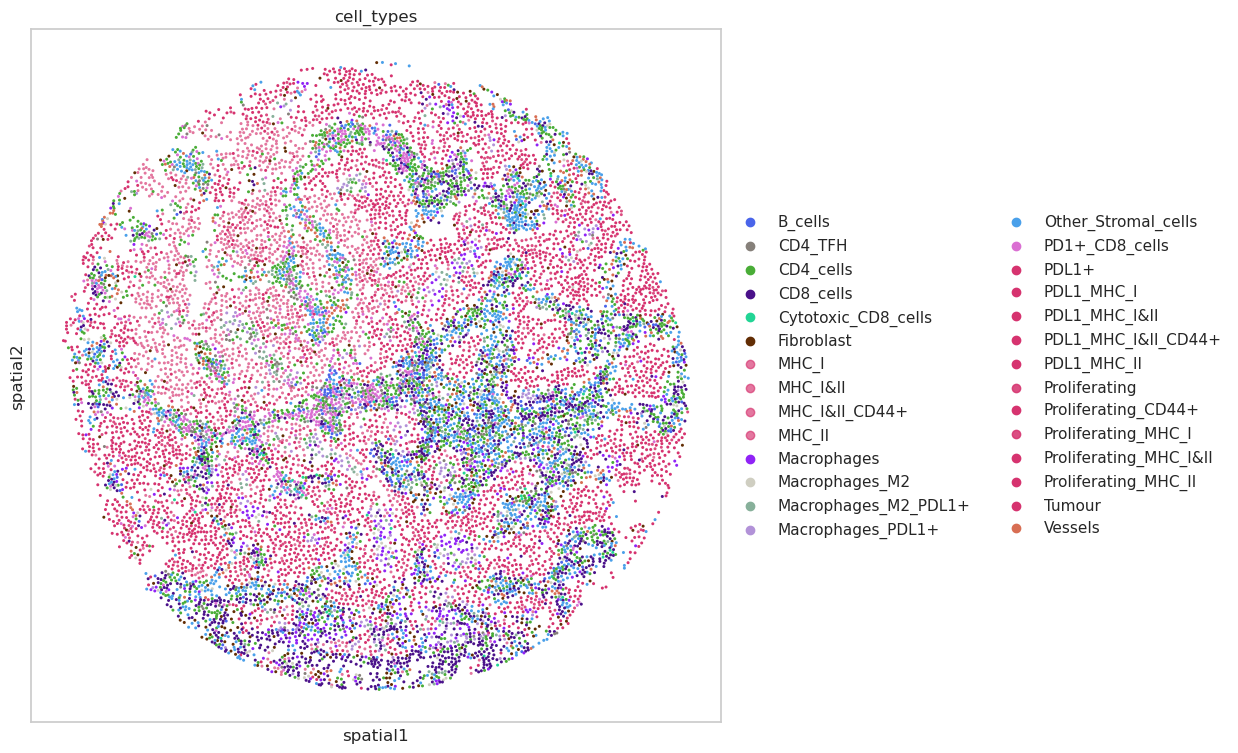

TMA_B_C5


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.23768122


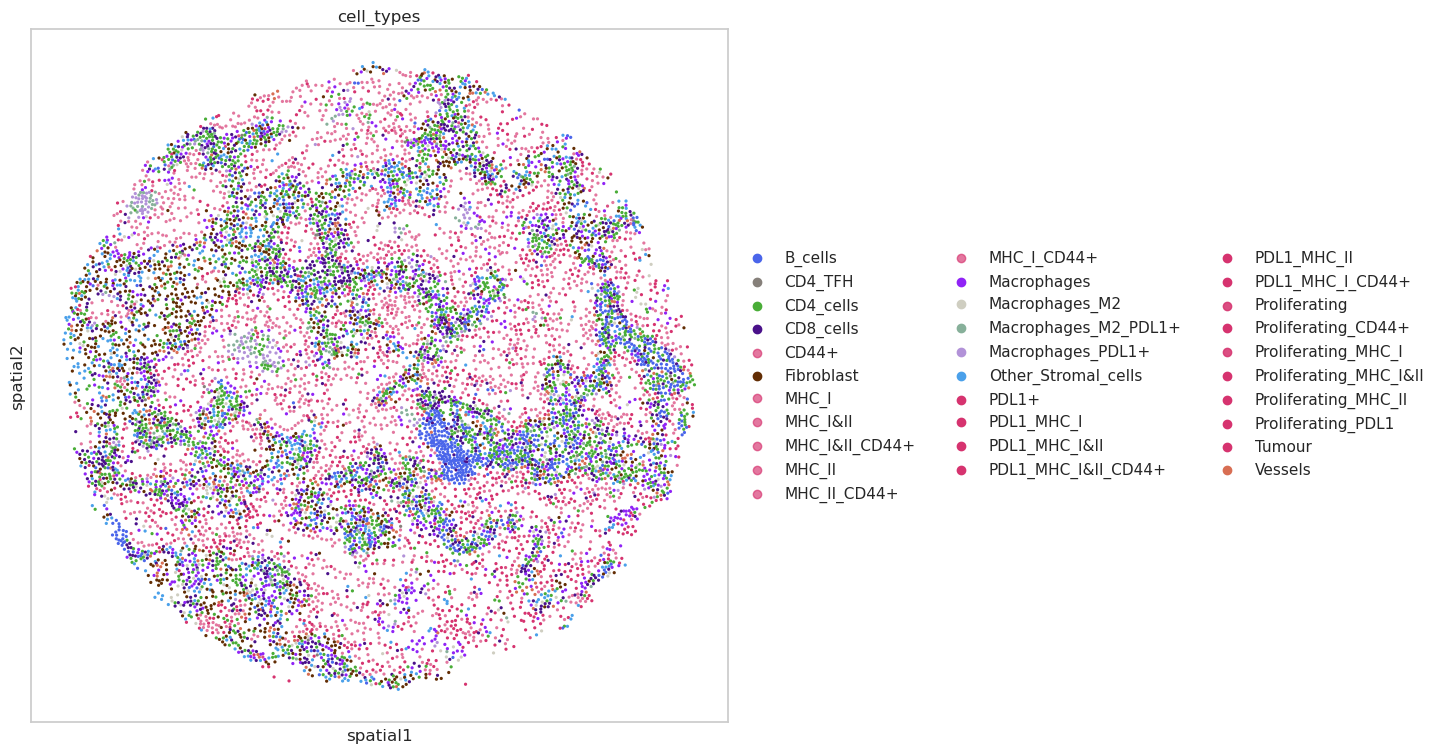

TMA_A_E7


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.8139176


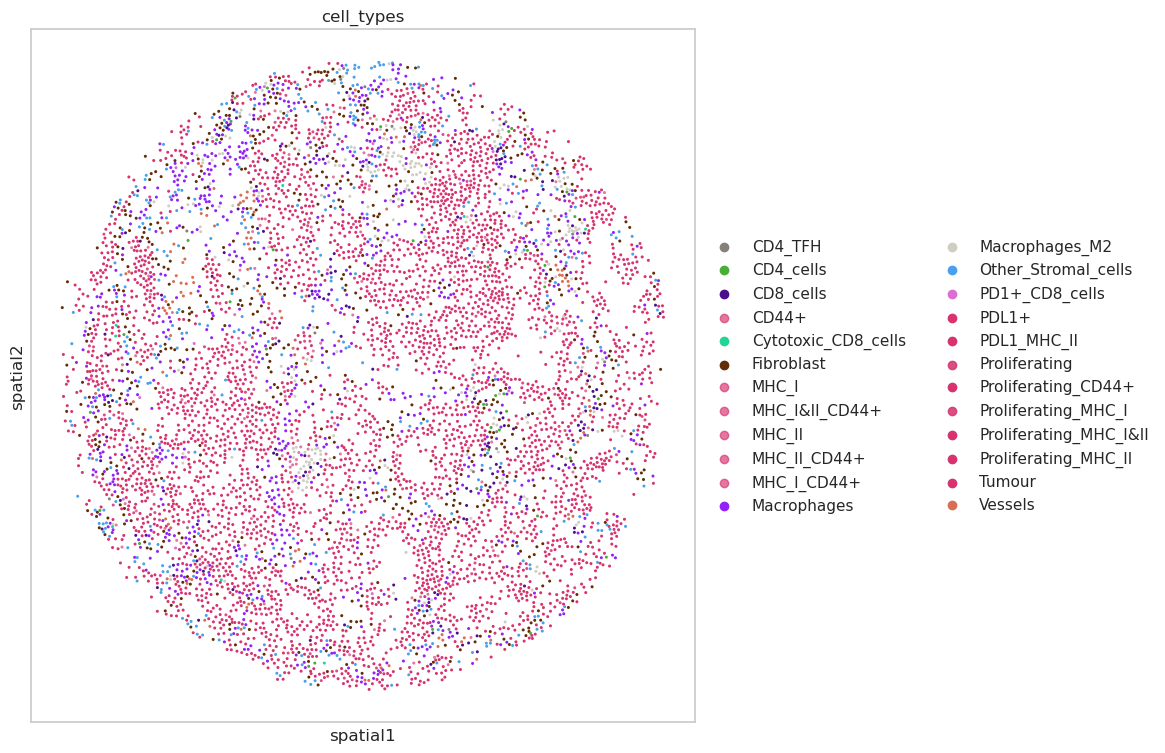

TMA_A_A6


/tmp/ipykernel_3268/1358922398.py:7: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T


Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.8280254



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7cfb7c466c20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

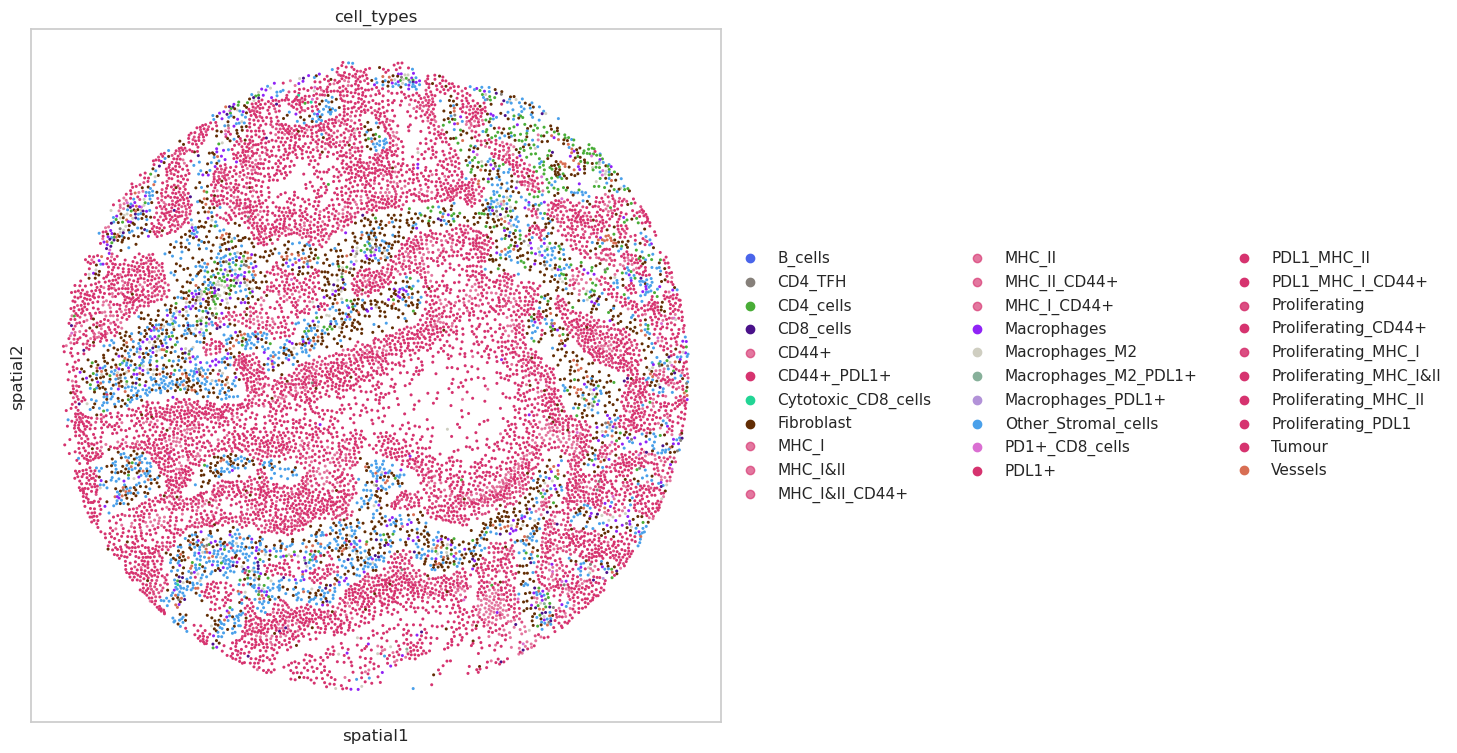

In [133]:
actual_relapse, pred_relapse = [], []
for pat in range(len(list(set(adata.obs['patient_id'])))):

    print(list(set(adata.obs['patient_id']))[pat])
    normadata = adata.copy()
    normadata = normadata[normadata.obs['patient_id'] == list(set(normadata.obs['patient_id']))[pat]]
    normadata.obsm['spatial'] = np.vstack([normadata.obs.x, normadata.obs.y]).T

    print("Remember, A score of 1 is Relapse")
    print("Actual Relapse: ", "No Relapse" if adata[adata.obs['patient_id'] == list(set(adata.obs['patient_id']))[pat]].obs.OR.iloc[0] == 0 else "Relapse")
    print("Predicted Relapse: ", normadata.obs['predictions'].mean())

    actual_relapse.append(adata[adata.obs['patient_id'] == list(set(adata.obs['patient_id']))[pat]].obs.OR.iloc[0])
    pred_relapse.append(normadata.obs['predictions'].mean())

    fig, ax = plt.subplots(ncols=1, figsize=(9, 9))
    ax.set_aspect('equal', 'box')
    ax.set_rasterization_zorder(0)
    sc.pl.spatial(normadata, color='cell_types', ax=ax, show=False, palette=cell_types_colors, spot_size=8)
    plt.savefig(f'{pat}_ct.tiff', dpi=400)
    plt.show()


In [49]:
normadata = adata.copy()

In [139]:
normadata

View of AnnData object with n_obs × n_vars = 4720 × 0
    obs: 'x', 'y', 'cell_types', 'predictions', 'patient_id', 'OR', 'pdl1_median_pos', 'pd1_median_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos', 'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'protein_exp_nb', 'Hypoxic', 'OxPhos', 'Mitochondrial', 'Oxidative_Stress', 'Lipid_Oxidation', 'PPP', 'Glutamine_import'
    obsm: 'cell_type_proportions'

In [180]:
actual_relapse, pred_relapse = [], []

for pat in adataClinical.obs['unique_core'].unique():

    if pat not in adata.obs['patient_id'].unique():
        continue

    print(pat)
    normadata = adata.copy()
    normadata.obsm['spatial'] = np.vstack([normadata.obs['x'], normadata.obs['y']]).T
    
    normadata = normadata[normadata.obs['patient_id'].astype(str) == pat]

    bol = normadata.obs['nb_tumour_nontumour_50_2'] == 'Tumour'

    print("Remember, A score of 1 is Relapse")
    print("Actual Relapse: ", "No Relapse" if normadata[normadata.obs['patient_id'] == pat,:].obs.OR.iloc[0] == 0 else "Relapse")
    print("Predicted Relapse: ", normadata.obs['predictions'].mean())
    print("Predicted Relapse TumourCells: ", normadata.obs.loc[bol.values, 'predictions'].mean())
    print("Predicted Relapse NonTumourCells: ", normadata.obs.loc[~bol.values, 'predictions'].mean())

    actual_relapse.append(adata[adata.obs['patient_id'] == pat].obs.OR.iloc[0])
    pred_relapse.append(normadata.obs['predictions'].mean())

TMA_A_A1
Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.8820902
Predicted Relapse TumourCells:  0.88734514
Predicted Relapse NonTumourCells:  0.8402802
TMA_A_A2
Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.70980364
Predicted Relapse TumourCells:  0.5883309
Predicted Relapse NonTumourCells:  0.7561793
TMA_A_A3
Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.83084583
Predicted Relapse TumourCells:  0.8554468
Predicted Relapse NonTumourCells:  0.72796446
TMA_A_A4
Remember, A score of 1 is Relapse
Actual Relapse:  No Relapse
Predicted Relapse:  0.21383934
Predicted Relapse TumourCells:  0.4120875
Predicted Relapse NonTumourCells:  0.19193995
TMA_A_A5
Remember, A score of 1 is Relapse
Actual Relapse:  Relapse
Predicted Relapse:  0.8180653
Predicted Relapse TumourCells:  0.5042857
Predicted Relapse NonTumourCells:  0.83480185
TMA_A_A6
Remember, A score of 1 is Relapse
Actual Relapse:  Re

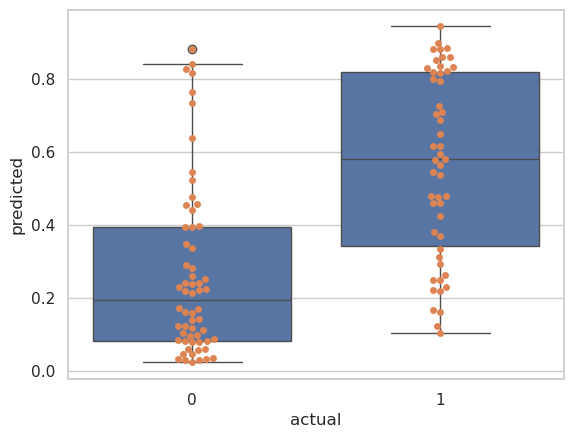

In [127]:
sns.boxplot(pd.DataFrame({'actual': actual_relapse, 'predicted': pred_relapse}), x='actual', y='predicted')
sns.swarmplot(pd.DataFrame({'actual': actual_relapse, 'predicted': pred_relapse}), x='actual', y='predicted')
plt.savefig('boxplot_predictions.svg')

In [156]:
actual_relapse.shape

(110, 98)

In [157]:
from sklearn.metrics import auc, precision_recall_curve

In [151]:
mat = sklearn.metrics.confusion_matrix(np.array(actual_relapse), np.array(pred_relapse) > 0.5)/54.0
print(sklearn.metrics.average_precision_score(np.array(actual_relapse), np.array(pred_relapse) > 0.5))
print(sklearn.metrics.precision_score(np.array(actual_relapse), np.array(pred_relapse) > 0.5))
print(sklearn.metrics.f1_score(np.array(actual_relapse), np.array(pred_relapse) > 0.5))
print(sklearn.metrics.roc_auc_score(np.array(actual_relapse), np.array(pred_relapse) > 0.5))

precision1, recall1, thresholds1 = precision_recall_curve(np.array(actual_relapse), np.array(pred_relapse) > 0.5)
plt.plot(1-recall1, precision1)
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.show()
print(auc(recall1, precision1))

sns.heatmap(pd.DataFrame(mat, index=["Relapse", "No-Relapse"], columns=["Pred Relapse", "Pred No-Relapse"]), cmap='viridis')
#plt.savefig('confusion.svg')

ValueError: multilabel-indicator is not supported

### Vary the cutoff and find optimal point

In [168]:
actual_relapse, pred_relapse, thresholds = [], [], []

for pat in adata.obs['patient_id'].unique()[~adata.obs['patient_id'].unique().isin(trainIds)]:
    print(pat)

    ars, prs, threshes = [], [], []
    
    #print(list(set(adata.obs['patient_id']))[pat])
    normadata = adata.copy()
    normadata = normadata[normadata.obs['patient_id'] == pat]
    
    #print("Remember, A score of 1 is Relapse")
    #print("Actual Relapse: ", "No Relapse" if adata[adata.obs['patient_id'] == list(set(adata.obs['patient_id']))[pat]].obs.OR.iloc[0] == 0 else "Relapse")
    #print("Predicted Relapse: ", normadata.obs['predictions'].mean())
    
    resp = adata[adata.obs['patient_id'] == pat].obs.OR.iloc[0]

    for cutoff in np.arange(0.02, 0.99, 0.01):
        preds = normadata.obs['predictions'].copy()
    
        ars.append(resp)

        preds[preds <  cutoff] = 0.0
        preds[preds >= cutoff] = 1.0

        prs.append(preds.mean())

    actual_relapse.append(ars)
    pred_relapse.append(prs)
    thresholds.append(np.arange(0.02, 0.99, 0.01))



TMA_A_A1
TMA_A_A3
TMA_A_A4
TMA_A_A7
TMA_A_B2
TMA_A_B5
TMA_A_B6
TMA_A_C4
TMA_A_C5
TMA_A_D1
TMA_A_D6
TMA_A_D7
TMA_A_E1
TMA_A_E3
TMA_A_E5
TMA_A_F4
TMA_A_F6
TMA_A_F7
TMA_A_G1
TMA_A_G3
TMA_A_G4
TMA_A_H2
TMA_A_H5
TMA_A_H6
TMA_A_H7
TMA_A_I2
TMA_A_I3
TMA_A_I4
TMA_A_I5
TMA_A_I6
TMA_A_J7
TMA_B_A8
TMA_B_B1
TMA_B_B2
TMA_B_B6
TMA_B_C1
TMA_B_C2
TMA_B_C6
TMA_B_C8
TMA_B_D3
TMA_B_D7
TMA_B_E2
TMA_B_E3
TMA_B_E4
TMA_B_E8
TMA_B_F5
TMA_B_G4
TMA_B_G7
TMA_B_H5
TMA_B_H6
TMA_B_I7
TMA_B_J2
TMA_B_J3
TMA_B_J4
TMA_B_J8


In [169]:
actual_relapse, pred_relapse, thresholds = np.array(actual_relapse), np.array(pred_relapse), np.array(thresholds)

Prec, F1, AUC, PRAUC = [], [], [], []
for cutoff in np.arange(0.02, 0.99, 0.01):
    #print(sklearn.metrics.average_precision_score(actual_relapse, pred_relapse < 0.5))
    #print(sklearn.metrics.precision_score(actual_relapse, pred_relapse < 0.5))
    #print(sklearn.metrics.f1_score(actual_relapse, pred_relapse < 0.5))
    #print(sklearn.metrics.roc_auc_score(actual_relapse, pred_relapse < 0.5))

    Prec.append(sklearn.metrics.precision_score(actual_relapse[thresholds == cutoff], pred_relapse[thresholds == cutoff] > 0.5))
    F1.append(sklearn.metrics.f1_score(actual_relapse[thresholds == cutoff], pred_relapse[thresholds == cutoff] > 0.5))
    AUC.append(sklearn.metrics.roc_auc_score(actual_relapse[thresholds == cutoff], pred_relapse[thresholds == cutoff] > 0.5))
    
    precision1, recall1, thresholds1 = precision_recall_curve(actual_relapse[thresholds == cutoff], pred_relapse[thresholds == cutoff] > 0.5)
    #print(auc(recall1, precision1))
    PRAUC.append(auc(recall1, precision1))

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

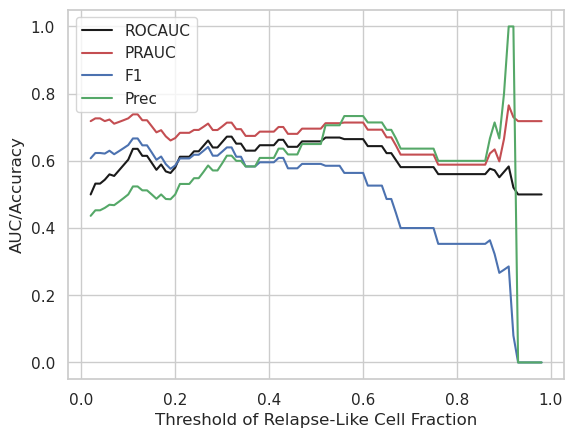

In [170]:
plt.plot(np.arange(0.02, 0.99, 0.01), AUC, 'k-', label='ROCAUC')
plt.plot(np.arange(0.02, 0.99, 0.01), PRAUC, 'r-', label='PRAUC')
plt.plot(np.arange(0.02, 0.99, 0.01), F1, 'b-', label='F1')
plt.plot(np.arange(0.02, 0.99, 0.01), Prec, 'g-', label='Prec')
plt.xlabel("Threshold of Relapse-Like Cell Fraction")
plt.ylabel("AUC/Accuracy")
plt.legend()
plt.savefig('variation3.svg')

## Better code

In [20]:
def returnKNNNeighbors(ndf, xcol, ycol, rad):
    """
    Computes k-nearest neighbor edges and the corresponding distances.
    
    Args:
        ndf (pd.DataFrame): DataFrame with at least x and y columns.
        xcol (str): Column name for x-coordinates.
        ycol (str): Column name for y-coordinates.
        rad (float): Radius to query neighbors.
        
    Returns:
        edges (np.ndarray): Array of shape (num_edges, 2) with each row as [source, destination].
        distances (np.ndarray): Array of distances corresponding to each edge.
    """
    edges, distances = [], []
    points = np.column_stack((ndf[xcol].to_numpy(), ndf[ycol].to_numpy()))
    tree = KDTree(points, leaf_size=2)
    all_nn_indices = tree.query_radius(points, r=rad)
    cdists = cdist(points, points)
    
    # Generate edges excluding self-loops
    for i, neighbors in enumerate(all_nn_indices):
        for neighbor in neighbors:
            if i != neighbor:
                edges.append([i, neighbor])
                distances.append(cdists[i, neighbor])
                
    return np.array(edges), np.array(distances)

def returnGraphWithXY(patientdf, ct_cols, rad, functional_cols):
    """
    Constructs a DGL graph from the patient DataFrame. The graph is built using k-NN
    of x-y coordinates, and node features are generated from one-hot encoded cell types (ct_cols)
    concatenated with additional functional columns.
    
    Args:
        patientdf (pd.DataFrame): Patient data including coordinates and features.
        ct_cols (list): List of cell type columns to include.
        rad (float): Radius to query neighbors.
        functional_cols (list): List of additional numeric columns to attach as node features.
        
    Returns:
        graph (dgl.DGLGraph): A bidirectional DGL graph with node features and edge distances.
        label (any): The patient label (here using the first entry of 'Relapse').
    """
    edges, distances = returnKNNNeighbors(patientdf, xcol='x', ycol='y', rad=rad)
    
    # Create DataFrame for edges and normalize distances (here, divide by 50 as in original code)
    edges_data = pd.DataFrame(edges, columns=['source', 'destination'])
    edges_data['distances'] = distances / 50.0
    
    # Build node features: one-hot encode the cell type and add functional columns.
    node_features = pd.get_dummies(patientdf['CT_basetumour']) \
        .reindex(columns=ct_cols, fill_value=False) \
        .astype(int).astype(float)
    node_features = pd.concat([node_features, patientdf[functional_cols]], axis=1)
    node_features = torch.from_numpy(node_features.to_numpy()).float()
    
    # Patient label (for example, 'Relapse' column is the classification target)
    node_label = torch.from_numpy(patientdf["Relapse"].astype("category")
                                 .cat.codes.to_numpy()).long()
    
    # Build the DGL graph
    edges_src = torch.from_numpy(edges_data["source"].to_numpy())
    edges_dst = torch.from_numpy(edges_data["destination"].to_numpy())
    graph = dgl.graph((edges_src, edges_dst), num_nodes=len(node_features))
    graph.ndata["feat"] = node_features
    # Store coordinates for visualization later
    graph.ndata['X'] = torch.from_numpy(patientdf['x'].to_numpy())
    graph.ndata['Y'] = torch.from_numpy(patientdf['y'].to_numpy())
    
    # Convert to bidirected (i.e. undirected graph)
    graph = dgl.to_bidirected(graph, copy_ndata=True)
    graph.edata['dist'] = torch.from_numpy(edges_data["distances"].to_numpy()).float()
    
    return graph, patientdf["Relapse"].iloc[0]

# ================================================================
# Subgraph Extraction and Prediction
# ================================================================

def compute_prediction_for_node(model, full_graph, target_node, label, batch_index, device, num_hops=2):
    """
    Extracts the k-hop subgraph around the target node, sets up the node and edge attributes,
    and computes the model output.
    
    Args:
        model: A pre-trained model (expects node features, edge indices, edge attributes, and graph IDs).
        full_graph (dgl.DGLGraph): The full input graph.
        target_node (int): The node index for which to compute the prediction.
        label: A label for the nodes (e.g. the patient relapse information).
        batch_index (int): An index to uniquely identify the subgraph batch.
        device: torch.device to send data to.
        num_hops (int): Number of hops to extract the local subgraph.
        
    Returns:
        pred (Tensor): Prediction output for the target subgraph.
        subgraph (dgl.DGLGraph): The extracted subgraph.
    """
    # Extract k-hop subgraph around the target node.
    subgraph, _ = dgl.khop_in_subgraph(full_graph, target_node, num_hops)
    
    # Set node labels and batch indices in the subgraph.
    num_sub_nodes = subgraph.number_of_nodes()
    subgraph.ndata['label'] = torch.full((num_sub_nodes,), label, dtype=torch.long)
    subgraph.ndata['batch'] = torch.full((num_sub_nodes,), batch_index, dtype=torch.int32)
    
    # Compute the edge index (as a tensor) from subgraph's edges.
    src, dst = subgraph.edges()
    edge_index = torch.stack([src, dst], dim=0).long()
    #subgraph.edata['edge_index'] = edge_index  # Optional: store for later reference

    # In this example, we'll use the edge_index as the tensor of edges.
    # (Alternatively, you can compute a stacked tensor of edges as in torch.vstack(subgraph.edges()))
    # For a single subgraph (not batched), we'll assign all nodes the same graph id (0).
    graph_ids = torch.zeros(num_sub_nodes, dtype=torch.long)
    
    # (Optional) If you want to collect distances globally:
    # distance_list = subgraph.edata["dist"].detach().cpu().numpy().tolist()
    
    # Pass data to device and compute the prediction.
    # The model call assumes the signature:
    #   model(node_features, edge_index, edge_attributes, graph_ids)
    pred = model(subgraph.ndata['feat'].to(device),
                 edge_index.to(device),
                 subgraph.edata["dist"].unsqueeze(-1).float().to(device),
                 graph_ids.to(device)
                ).sigmoid().detach().cpu()
    
    return pred, subgraph

def generate_predictions_for_all_nodes(model, full_graph, label, device, num_hops=2):
    """
    Iterates over every node in the full graph, extracts its k-hop subgraph,
    and computes the model output.
    
    Args:
        model: Pre-trained graph model.
        full_graph (dgl.DGLGraph): The full input graph.
        label: Patient label (or any common label) for the subgraphs.
        device: torch.device to use.
        num_hops (int): Number of hops for subgraph extraction.
        
    Returns:
        predictions (dict): A dictionary mapping global node indices to predictions.
    """
    predictions = {}
    batch_index = 0  # Unique index for subgraph batches
    
    total_nodes = full_graph.number_of_nodes()
    for node_idx in range(total_nodes):
        if node_idx % 100 == 0:
            print(f"Processing node {node_idx} / {total_nodes}", end='\r')
        
        pred, subgraph = compute_prediction_for_node(
            model, full_graph, node_idx, label, batch_index, device, num_hops=num_hops
        )
        predictions[node_idx] = pred
        batch_index += 1
        
    return predictions

In [20]:
results = pd.DataFrame()

for graphI, (unique_core, patdf) in enumerate(df.groupby(by='unique_core')):
    print(f"Running on core {unique_core}")
    if np.isnan(patdf['Relapse'].iloc[0]):
       continue

    full_graph, patient_label = returnGraphWithXY(patdf, ct_cols, 80.0, functional_cols)
    all_predictions = generate_predictions_for_all_nodes(model, full_graph, patient_label, device, num_hops=2)

    patresults = pd.DataFrame({'pred': [a[0][0] for _, a in all_predictions.items()], 'relapse': patdf['Relapse'].iloc[0]*np.ones_like(all_predictions), 'x': np.array(full_graph.ndata['X']), 'y': np.array(full_graph.ndata['Y']), 'ct': ['_'.join([marker_cols[a] for a in np.where(full_graph.ndata['feat'][i,:])[0]]) for i in range(full_graph.ndata['feat'].shape[0])], })
    full_graph.ndata['predictions'] = torch.tensor([a[0][0] for _, a in all_predictions.items()])

    smaller_graph, patient_label = returnGraphWithXY(patdf, ct_cols, 20.0, functional_cols)
    smaller_graph.ndata['predictions'] = torch.tensor([a[0][0] for _, a in all_predictions.items()])

    
    results = pd.concat([results, patresults], axis=0) 
    

Running on core TMA_A_A1
Running on core TMA_A_A2873
Running on core TMA_A_A312664
Running on core TMA_A_A4203
Running on core TMA_A_A5922
Running on core TMA_A_A613093
Running on core TMA_A_A713978
Processing node 10200 / 14405


KeyboardInterrupt

